# Content

[1. Setup](#Setup-&-Import)

[2. Checks and Setup Modelling](#Checks-Timeseries-&-Setup-Modelling)

[3. VARMAX](#VARMAX)

# Setup & Import¶

In [1]:
#import basic system functions
import os
import datetime
from collections import Counter
import itertools

import random

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
# If you want a style choose one
#plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'



#import libraries for time series analysis
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX

#import libraries for statistics
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime
import holidays

In [330]:
df_1= pd.read_csv("df_new_1.csv")

In [27]:
df_2= pd.read_csv("df_new_2.csv")

In [493]:
df_2_clean= pd.read_csv("data_2_clean.csv")

In [332]:
df_3= pd.read_csv("df_new_3.csv")

In [32]:
#df_1.drop(columns=['Unnamed: 0'],inplace=True)
#df_2_clean.drop(columns=['Unnamed: 0'],inplace=True)
#df_2.drop(columns=['Unname: 0'],inplace=True)
df_2.drop(columns=['Ostern_y','Ostern_x'],inplace=True)
#df_3.drop(columns=['Unnamed: 0'],inplace=True)

In [33]:
df_2.columns

Index(['Datum', 'Weizenbrot', 'Mischbrot', 'Vollkornbrot', 'Stangenbrote',
       'Spezialbrot', 'Brötchen', 'Süsse_Brötchen', 'Herzhafte_Brötchen',
       'KonditoreiBlech', 'Stückgebäck', 'Blechkuchen', 'Weihnachtsartikel',
       'Wochentag', 'Tag', 'Jahr', 'Monat', 'Gesamt', 'Wochenende_flag',
       'Season', 'Christmas', 'Closed', 'Outlier', 'New_Years_Eve',
       'Feiertag_DE', 'Holidays_SH', 'SUMMER_SH', 'Niederschlag', 'Sonne_h',
       'Temperatur_max', 'Ostern'],
      dtype='object')

## Convert to datetime

In [102]:
df_2_dum['Datum'] = pd.to_datetime(df_2_dum['Datum'])

In [749]:
df_1['Datum'] = pd.to_datetime(df_1['Datum'])
df_2['Datum'] = pd.to_datetime(df_2['Datum'])
df_2_clean['Datum'] = pd.to_datetime(df_2['Datum'])
df_3['Datum'] = pd.to_datetime(df_3['Datum'])

## Modifiying categorical features

In [34]:
month_dummy= pd.get_dummies(df_2['Monat'], prefix='M', drop_first=True)

In [35]:
weekday_dummy= pd.get_dummies(df_2['Wochentag'], prefix='W', drop_first=True)

In [ ]:
year_dummy= pd.get_dummies(df_new_2['Jahr'], prefix='J', drop_first=True)

In [36]:
season_dummy=pd.get_dummies(df_2['Season'], prefix='S', drop_first=True)

In [37]:
df_2_dum = df_2.drop(['Tag','Monat','Wochentag','Jahr','Season'], axis=1,inplace=True) 

In [38]:
df_2_dum = pd.concat([df_2,month_dummy,weekday_dummy,season_dummy], axis=1) 

In [39]:
df_2_dum.columns

Index(['Datum', 'Weizenbrot', 'Mischbrot', 'Vollkornbrot', 'Stangenbrote',
       'Spezialbrot', 'Brötchen', 'Süsse_Brötchen', 'Herzhafte_Brötchen',
       'KonditoreiBlech', 'Stückgebäck', 'Blechkuchen', 'Weihnachtsartikel',
       'Gesamt', 'Wochenende_flag', 'Christmas', 'Closed', 'Outlier',
       'New_Years_Eve', 'Feiertag_DE', 'Holidays_SH', 'SUMMER_SH',
       'Niederschlag', 'Sonne_h', 'Temperatur_max', 'Ostern', 'M_2', 'M_3',
       'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 'M_10', 'M_11', 'M_12', 'W_1',
       'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'S_2', 'S_3', 'S_4'],
      dtype='object')

## Distribution

### Filiale 1

In [342]:
df_1.iloc[:,0:12].skew()

Weizenbrot           -0.847051
Mischbrot            -1.422027
Vollkornbrot         -0.618398
Stangenbrote         -1.241831
Spezialbrot           1.051926
Brötchen             -0.849809
Süsse_Brötchen       -0.996482
Herzhafte_Brötchen   -0.231355
KonditoreiBlech      -0.121421
Stückgebäck           1.600569
Blechkuchen           0.248526
dtype: float64

In [343]:
df_1.iloc[:,0:12].describe().T

count        mean         std        min         25%  \
Weizenbrot          1979.0   47.499244   25.668227   0.000000   41.401207   
Mischbrot           1979.0  119.746911   55.522856   0.000000  121.724683   
Vollkornbrot        1979.0   95.075456   49.503083   0.000000   83.451370   
Stangenbrote        1979.0  105.259887   51.084768   0.000000  106.887926   
Spezialbrot         1979.0   15.356776   14.661447 -19.456941    2.078421   
Brötchen            1979.0  195.899909   96.660050   0.000000  181.622801   
Süsse_Brötchen      1979.0  148.535635   71.178235   0.000000  146.563434   
Herzhafte_Brötchen  1979.0  119.832465   63.610233   0.000000   99.840378   
KonditoreiBlech     1979.0   97.295063   55.882927   0.000000   72.465289   
Stückgebäck         1979.0  171.684369  103.661861   0.000000  137.954726   
Blechkuchen         1979.0   89.653765   56.482974   0.000000   61.021325   

                           50%         75%          max  
Weizenbrot           54.536053   64.201839   108.483580  
Mischbrot           137.410662  150.339334   278.525803  
Vollkornbrot        103.895850  122.855409   355.486188  
Stangenbrote        121.463482  133.116601   250.548161  
Spezialbrot          13.973366   24.010848   127.115673  
Brötchen            221.906222  252.181492   819.482643  
Süsse_Brötchen      166.113798  185.588769   602.291890  
Herzhafte_Brötchen  134.965996  160.066325   772.490394  
KonditoreiBlech      99.780142  134.187943   368.820992  
Stückgebäck         184.768638  222.008016  1091.655623  
Blechkuchen          90.512143  125.562482   440.259806

### Filiale 2

In [344]:
df_2.iloc[:,0:12].skew()

Weizenbrot            -1.294661
Mischbrot             -0.812645
Vollkornbrot          -1.136906
Stangenbrote           0.975517
Spezialbrot           -0.738421
Brötchen               0.279051
Süsse_Brötchen        -0.085687
Herzhafte_Brötchen     0.701135
KonditoreiBlech        1.052673
Stückgebäck           12.182137
Blechkuchen            0.678147
dtype: float64

In [397]:
# Valuation of agg.Values
df_1.iloc[:,0:12].describe().T

count        mean         std        min         25%  \
Weizenbrot          1979.0   47.499244   25.668227   0.000000   41.401207   
Mischbrot           1979.0  119.746911   55.522856   0.000000  121.724683   
Vollkornbrot        1979.0   95.075456   49.503083   0.000000   83.451370   
Stangenbrote        1979.0  105.259887   51.084768   0.000000  106.887926   
Spezialbrot         1979.0   15.356776   14.661447 -19.456941    2.078421   
Brötchen            1979.0  195.899909   96.660050   0.000000  181.622801   
Süsse_Brötchen      1979.0  148.535635   71.178235   0.000000  146.563434   
Herzhafte_Brötchen  1979.0  119.832465   63.610233   0.000000   99.840378   
KonditoreiBlech     1979.0   97.295063   55.882927   0.000000   72.465289   
Stückgebäck         1979.0  171.684369  103.661861   0.000000  137.954726   
Blechkuchen         1979.0   89.653765   56.482974   0.000000   61.021325   

                           50%         75%          max  
Weizenbrot           54.536053   64.201839   108.483580  
Mischbrot           137.410662  150.339334   278.525803  
Vollkornbrot        103.895850  122.855409   355.486188  
Stangenbrote        121.463482  133.116601   250.548161  
Spezialbrot          13.973366   24.010848   127.115673  
Brötchen            221.906222  252.181492   819.482643  
Süsse_Brötchen      166.113798  185.588769   602.291890  
Herzhafte_Brötchen  134.965996  160.066325   772.490394  
KonditoreiBlech      99.780142  134.187943   368.820992  
Stückgebäck         184.768638  222.008016  1091.655623  
Blechkuchen          90.512143  125.562482   440.259806

### Filiale 3

In [346]:
df_3.iloc[:,0:12].skew()

Weizenbrot            -1.379242
Mischbrot             -0.218946
Vollkornbrot          -0.327030
Stangenbrote           1.449703
Spezialbrot            2.631715
Brötchen               1.206183
Süsse_Brötchen         1.540347
Herzhafte_Brötchen     1.128812
KonditoreiBlech        2.043403
Stückgebäck           11.555112
Blechkuchen            1.352157
dtype: float64

In [347]:
# Valuation of agg.Values
df_3.iloc[:,0:12].describe().T

count        mean         std        min         25%  \
Weizenbrot          1979.0   94.590422   43.236697   0.000000   92.485399   
Mischbrot           1979.0   69.590797   25.237483  -8.206057   55.500924   
Vollkornbrot        1979.0  139.808866   42.935777   0.000000  114.609440   
Stangenbrote        1979.0   67.399913   29.442222   0.000000   52.037613   
Spezialbrot         1979.0   24.877398   19.001696 -13.303934   13.795489   
Brötchen            1979.0  501.963348  280.540572   0.000000  324.489922   
Süsse_Brötchen      1979.0  122.077434   84.208370   0.000000   72.949762   
Herzhafte_Brötchen  1979.0  125.435456   53.994161   0.000000   93.058875   
KonditoreiBlech     1979.0  121.808912   59.562777   0.000000   90.853838   
Stückgebäck         1979.0  262.764221  155.521554   0.000000  204.065161   
Blechkuchen         1979.0  139.302938   73.055950   0.000000   95.872781   

                           50%         75%          max  
Weizenbrot          107.679332  119.375908   192.988351  
Mischbrot            70.945641   85.243652   173.540362  
Vollkornbrot        137.568891  164.886430   289.743854  
Stangenbrote         66.082557   81.417465   360.234576  
Spezialbrot          22.209939   32.948350   196.397215  
Brötchen            379.389514  639.296037  1427.908880  
Süsse_Brötchen       88.018136  140.350435   419.585626  
Herzhafte_Brötchen  113.218174  145.588495   369.186424  
KonditoreiBlech     107.021928  132.867947   602.524967  
Stückgebäck         246.423376  297.820038  3154.149267  
Blechkuchen         123.450001  165.662391   668.105141

## Correlations

<AxesSubplot:title={'center':'Korrelation nach Pearson für Brötchen'}>

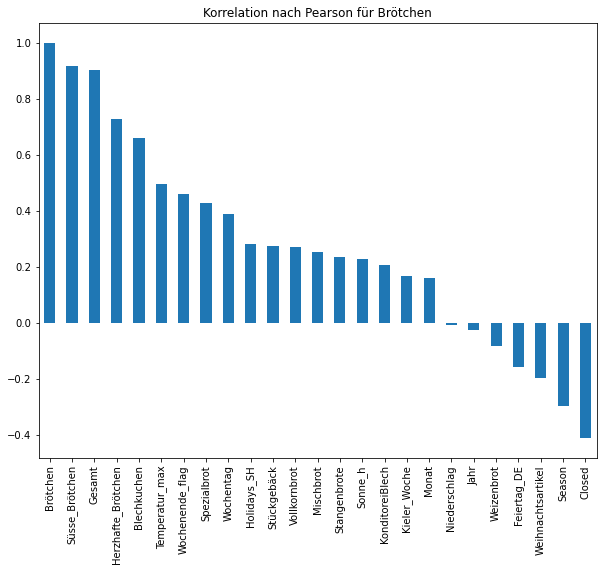

In [348]:
# correlation für Brötchen
basis=num_df.corr(method='pearson')['Brötchen'].sort_values(axis=0, ascending=False)
basis.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson für Brötchen')

<function matplotlib.pyplot.show(close=None, block=None)>

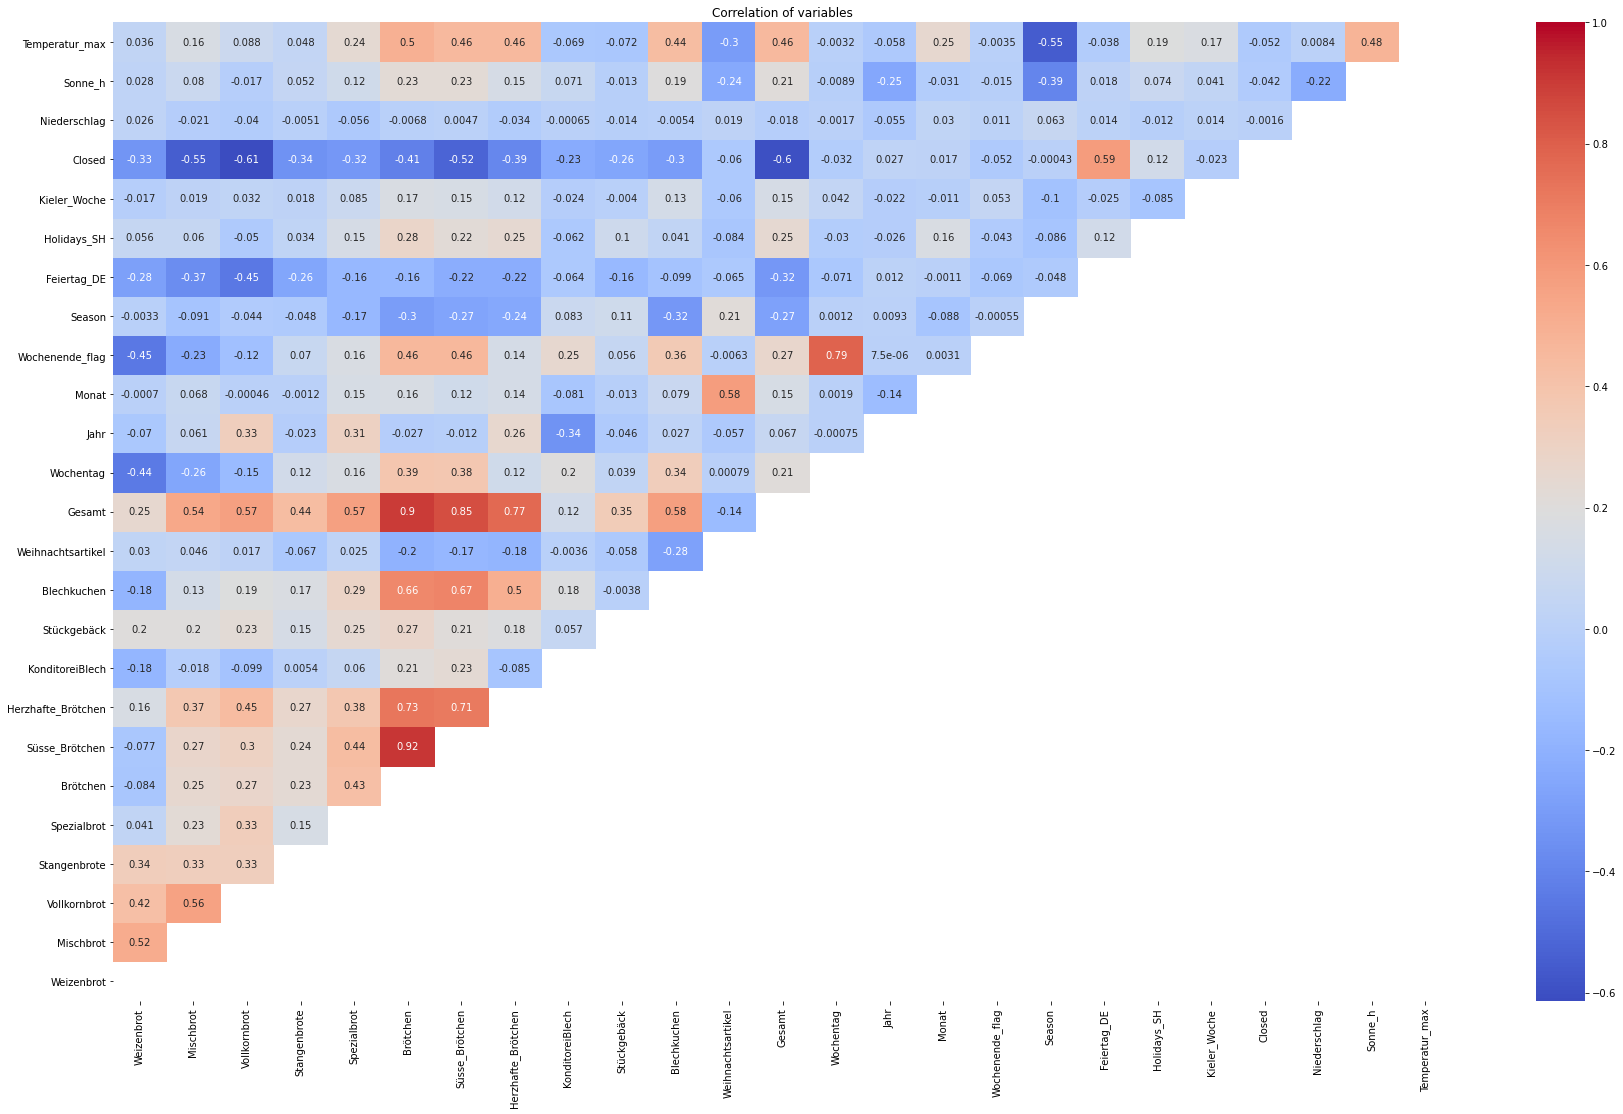

In [349]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df = df_2.select_dtypes(include=numerics)

#Korrelationsanalyse
mask = np.triu( num_df.corr())
plt.figure(figsize=(30,18))
plt.title('Correlation of variables')
ax=sns.heatmap(num_df.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,25))
plt.show

In [ ]:
df_2.to_csv("df_new_2.csv")

# Outlier Handling

In [398]:
df_2.columns

Index(['Unnamed: 0', 'Datum', 'Weizenbrot', 'Mischbrot', 'Vollkornbrot',
       'Stangenbrote', 'Spezialbrot', 'Brötchen', 'Süsse_Brötchen',
       'Herzhafte_Brötchen', 'KonditoreiBlech', 'Stückgebäck', 'Blechkuchen',
       'Weihnachtsartikel', 'Wochentag', 'Tag', 'Jahr', 'Monat', 'Gesamt',
       'Wochenende_flag', 'Season', 'Closed', 'Outlier', 'Feiertag_DE',
       'Holidays_SH', 'Kieler_Woche', 'Niederschlag', 'Sonne_h',
       'Temperatur_max'],
      dtype='object')

## Filiale 2

In [40]:
data_2_clean=df_2.copy()

In [400]:
Weizenbrot_result = np.percentile(df_2.Weizenbrot, q=[0, 25, 50, 75, 90, 95,99])
print(Weizenbrot_result)

[  0.          60.11725773  71.63807461  81.29592564  89.82744513
  95.07012014 106.46010925]


In [41]:
df_2.query('Weizenbrot>106.46010925')[['Datum','Weizenbrot','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum  Weizenbrot  Wochenende_flag  Feiertag_DE  Holidays_SH
37    2015-02-07  106.766712                1            0          0.0
93    2015-04-04  116.676337                1            0          1.0
141   2015-05-22  106.543603                0            0          0.0
210   2015-07-30  115.564197                0            0          1.0
212   2015-08-01  116.361146                1            0          1.0
216   2015-08-05  113.517230                0            0          1.0
219   2015-08-08  116.378383                1            0          1.0
461   2016-04-06  107.471310                0            0          1.0
580   2016-08-03  112.517902                0            0          1.0
583   2016-08-06  108.571610                1            0          1.0
585   2016-08-08  114.115974                0            0          1.0
723   2016-12-24  120.423144                1            0          1.0
730   2016-12-31  106.897727                1            0          1.0
835   2017-04-15  108.085267                1            0          1.0
1005  2017-10-02  110.796822                0            0          0.0
1185  2018-03-31  111.731683                1            0          1.0
1297  2018-07-21  106.604591                1            0          1.0
1535  2019-03-16  109.972172                1            0          0.0
1570  2019-04-20  110.726016                1            0          0.0
1619  2019-06-08  113.494473                1            0          0.0

In [42]:
data_2_clean['Weizenbrot']=data_2_clean['Weizenbrot'].apply(lambda x: x if x <106.46010925 else 'NaN' )


### Mischbrot

In [43]:
data_2_clean['Mischbrot']=data_2_clean['Mischbrot'].apply(lambda x: x if x >0 else 0 )

In [404]:
df_2.Mischbrot.describe(percentiles=[ 0.9, 0.99])

count    1979.000000
mean       71.860719
std        20.052765
min         0.000000
50%        73.463033
90%        94.252644
99%       116.017187
max       152.746146
Name: Mischbrot, dtype: float64

In [405]:
df_2.query('Mischbrot>116')[['Datum','Mischbrot','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum   Mischbrot  Wochenende_flag  Feiertag_DE  Holidays_SH
833  2017-04-13  116.385102                0            0          1.0
835  2017-04-15  125.202761                1            0          1.0
935  2017-07-24  125.962501                0            0          1.0
938  2017-07-27  123.377251                0            0          1.0
942  2017-07-31  129.402961                0            0          1.0
1012 2017-10-09  116.137825                0            0          0.0
1183 2018-03-29  137.481488                0            0          1.0
1261 2018-06-15  119.760341                0            0          0.0
1285 2018-07-09  117.475546                0            0          1.0
1292 2018-07-16  119.483012                0            0          1.0
1436 2018-12-07  117.178730                0            0          0.0
1568 2019-04-18  133.888669                0            0          1.0
1573 2019-04-23  117.252371                0            0          0.0
1649 2019-07-08  117.293070                0            0          1.0
1665 2019-07-24  121.316661                0            0          1.0
1667 2019-07-26  126.779521                0            0          1.0
1682 2019-08-10  135.369412                1            0          0.0
1788 2019-11-24  126.910020                1            0          0.0
1901 2020-03-16  118.033376                0            0          0.0
1954 2020-05-08  152.746146                0            0          0.0

In [44]:
data_2_clean['Mischbrot']=data_2_clean['Mischbrot'].apply(lambda x: x if x <116 else 'NaN' )

### Vollkornbrot

In [407]:
df_2.Vollkornbrot.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean      108.283982
std        26.926271
min         0.000000
50%       108.428509
90%       139.188596
99%       165.980698
max       225.035588
Name: Vollkornbrot, dtype: float64

In [408]:
#df_2.query('Vollkornbrot>165.980698')[['Datum','Vollkornbrot','Wochenende_flag','Feiertag_DE','Holidays_SH']]

In [45]:
data_2_clean['Vollkornbrot']=data_2_clean['Vollkornbrot'].apply(lambda x: x if x <165.980698 else 'NaN' )

### Spezialbrot

In [410]:
df_2.Spezialbrot.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean       56.310284
std        26.874605
min         0.000000
50%        61.850288
90%        80.372255
99%       106.508961
max       200.259200
Name: Spezialbrot, dtype: float64

In [411]:
#df_2.query('Spezialbrot>106.508961')[['Datum','Spezialbrot','Wochenende_flag','Feiertag_DE','Holidays_SH']]

In [46]:
data_2_clean['Spezialbrot']=data_2_clean['Spezialbrot'].apply(lambda x: x if x <165.980698 else 'NaN' )

### Stangenbrote

In [413]:
df_2.Stangenbrote.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean       39.816439
std        17.646559
min         0.000000
50%        39.332197
90%        59.523275
99%        82.606569
max       198.752191
Name: Stangenbrote, dtype: float64

In [414]:
#df_2.query('Stangenbrote>82.606569')[['Datum','Stangenbrote','Wochenende_flag','Feiertag_DE','Holidays_SH']]

In [47]:
data_2_clean['Stangenbrote']=data_2_clean['Stangenbrote'].apply(lambda x: x if x <82.606569 else 'NaN' )

### Brötchen

In [416]:
df_2.Brötchen.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean      375.431206
std       138.927415
min         0.000000
50%       355.500769
90%       573.698524
99%       736.781705
max       820.516093
Name: Brötchen, dtype: float64

In [417]:
df_2.query('Brötchen>736.781705')[['Datum','Brötchen','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum    Brötchen  Wochenende_flag  Feiertag_DE  Holidays_SH
95   2015-04-06  737.004266                0            1          1.0
177  2015-06-27  743.175388                1            0          0.0
206  2015-07-26  739.086126                1            0          1.0
213  2015-08-02  770.762031                1            0          1.0
541  2016-06-25  772.567025                1            0          0.0
1297 2018-07-21  769.241046                1            0          1.0
1325 2018-08-18  766.553081                1            0          0.0
1570 2019-04-20  810.818652                1            0          0.0
1571 2019-04-21  762.131477                1            0          0.0
1572 2019-04-22  744.701161                0            1          0.0
1640 2019-06-29  767.585518                1            0          0.0
1641 2019-06-30  747.700464                1            0          0.0
1668 2019-07-27  738.389482                1            0          1.0
1669 2019-07-28  744.244725                1            0          1.0
1675 2019-08-03  768.114067                1            0          1.0
1676 2019-08-04  820.516093                1            0          1.0
1682 2019-08-10  747.885520                1            0          0.0
1954 2020-05-08  755.283725                0            0          0.0
1976 2020-05-30  754.876900                1            0          0.0
1978 2020-06-01  760.991692                0            1          0.0

In [48]:
data_2_clean['Brötchen']=data_2_clean['Brötchen'].apply(lambda x: x if x <736.781705 else 'NaN' )

### Süsse Brötchen

In [419]:
df_2.Süsse_Brötchen.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean      196.670399
std        57.579214
min         0.000000
50%       185.408152
90%       274.316402
99%       345.075359
max       428.071519
Name: Süsse_Brötchen, dtype: float64

In [420]:
#df_2.query('Süsse_Brötchen>345.075359')[['Datum','Süsse_Brötchen','Wochenende_flag','Feiertag_DE','Holidays_SH']]

In [49]:
data_2_clean['Süsse_Brötchen']=data_2_clean['Süsse_Brötchen'].apply(lambda x: x if x <345.075359 else 'NaN' )

### Herzhafte Brötchen

In [422]:
df_2.Herzhafte_Brötchen.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean       93.947422
std        36.940020
min         0.000000
50%        87.759013
90%       142.352808
99%       203.997358
max       268.706655
Name: Herzhafte_Brötchen, dtype: float64

In [423]:
df_2.query('Herzhafte_Brötchen>203.997358')[['Datum','Herzhafte_Brötchen','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum  Herzhafte_Brötchen  Wochenende_flag  Feiertag_DE  Holidays_SH
1291 2018-07-15          205.004841                1            0          1.0
1298 2018-07-22          218.275924                1            0          1.0
1306 2018-07-30          208.208486                0            0          1.0
1311 2018-08-04          232.411259                1            0          1.0
1325 2018-08-18          218.438997                1            0          0.0
1326 2018-08-19          209.905315                1            0          0.0
1543 2019-03-24          213.660279                1            0          0.0
1633 2019-06-22          205.960300                1            0          0.0
1634 2019-06-23          221.737360                1            0          0.0
1640 2019-06-29          244.708756                1            0          0.0
1641 2019-06-30          205.233009                1            0          0.0
1654 2019-07-13          230.165745                1            0          1.0
1664 2019-07-23          204.031376                0            0          1.0
1665 2019-07-24          218.820718                0            0          1.0
1668 2019-07-27          234.409088                1            0          1.0
1677 2019-08-05          211.666771                0            0          1.0
1678 2019-08-06          224.718959                0            0          1.0
1969 2020-05-23          217.614049                1            0          0.0
1970 2020-05-24          219.369779                1            0          0.0
1976 2020-05-30          268.706655                1            0          0.0

In [50]:
data_2_clean['Herzhafte_Brötchen']=data_2_clean['Herzhafte_Brötchen'].apply(lambda x: x if x <203.997358 else 'NaN' )

### KonditoreiBlech

In [425]:
df_2.KonditoreiBlech.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean       98.692646
std        64.111577
min         0.000000
50%        73.102484
90%       193.462493
99%       275.632008
max       399.988543
Name: KonditoreiBlech, dtype: float64

In [426]:
df_2.query('KonditoreiBlech>275.632008')[['Datum','KonditoreiBlech','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum  KonditoreiBlech  Wochenende_flag  Feiertag_DE  Holidays_SH
17  2015-01-18       326.082164                1            0          0.0
31  2015-02-01       284.671715                1            0          0.0
38  2015-02-08       351.096954                1            0          0.0
52  2015-02-22       399.988543                1            0          0.0
66  2015-03-08       296.794889                1            0          0.0
332 2015-11-29       307.686998                1            0          0.0
399 2016-02-04       288.379119                0            0          0.0
402 2016-02-07       278.672843                1            0          0.0
408 2016-02-13       283.452860                1            0          0.0
409 2016-02-14       347.929304                1            0          0.0
416 2016-02-21       378.238625                1            0          0.0
501 2016-05-16       309.346264                0            1          1.0
535 2016-06-19       286.364778                1            0          0.0
590 2016-08-13       276.546387                1            0          1.0
738 2017-01-08       308.554695                1            0          0.0
745 2017-01-15       330.130000                1            0          0.0
787 2017-02-26       316.640394                1            0          0.0
801 2017-03-12       277.100833                1            0          0.0
829 2017-04-09       333.813387                1            0          1.0
850 2017-04-30       280.286768                1            0          0.0

In [51]:
data_2_clean['KonditoreiBlech>']=data_2_clean['KonditoreiBlech'].apply(lambda x: x if x <275.632008 else 'NaN' )

### Blechkuchen

In [428]:
df_2.Blechkuchen.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean       93.154924
std        46.648699
min         0.000000
50%        87.470191
90%       155.746063
99%       222.225412
max       338.496148
Name: Blechkuchen, dtype: float64

In [429]:
df_2.query('Blechkuchen>222.225412')[['Datum','Blechkuchen','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum  Blechkuchen  Wochenende_flag  Feiertag_DE  Holidays_SH
144  2015-05-25   237.669884                0            1          0.0
157  2015-06-07   227.839234                1            0          0.0
247  2015-09-05   275.758250                1            0          0.0
261  2015-09-19   250.168163                1            0          0.0
590  2016-08-13   284.154770                1            0          1.0
597  2016-08-20   247.344333                1            0          1.0
954  2017-08-12   338.496148                1            0          1.0
955  2017-08-13   282.968118                1            0          1.0
962  2017-08-20   263.313403                1            0          1.0
1269 2018-06-23   293.819720                1            0          0.0
1333 2018-08-26   270.915773                1            0          0.0
1508 2019-02-17   229.121269                1            0          0.0
1606 2019-05-26   222.775376                1            0          0.0
1640 2019-06-29   257.774312                1            0          0.0
1653 2019-07-12   223.855530                0            0          1.0
1654 2019-07-13   223.780099                1            0          1.0
1655 2019-07-14   235.872790                1            0          1.0
1690 2019-08-18   239.976503                1            0          0.0
1954 2020-05-08   223.740035                0            0          0.0
1977 2020-05-31   236.650859                1            0          0.0

In [430]:
data_2_clean['Blechkuchen>']=data_2_clean['Blechkuchen'].apply(lambda x: x if x <222.225412 else 'NaN' )

### Stückgebäck

In [431]:
df_2.Stückgebäck.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean      152.085738
std        89.090462
min         0.000000
50%       145.715536
90%       203.852504
99%       303.260565
max      1798.588913
Name: Stückgebäck, dtype: float64

In [432]:
df_2.query('Stückgebäck>303.260565')[['Datum','Stückgebäck','Wochenende_flag','Feiertag_DE','Holidays_SH']]

Datum  Stückgebäck  Wochenende_flag  Feiertag_DE  Holidays_SH
30   2015-01-31   354.256675                1            0          0.0
36   2015-02-06   310.621273                0            0          0.0
38   2015-02-08   374.498321                1            0          0.0
52   2015-02-22   391.333295                1            0          0.0
93   2015-04-04   375.265090                1            0          1.0
363  2015-12-30   308.432863                0            0          1.0
364  2015-12-31  1798.588913                0            0          1.0
729  2016-12-30   357.710139                0            0          1.0
730  2016-12-31  1639.124849                1            0          1.0
1094 2017-12-30   420.581338                1            0          1.0
1095 2017-12-31  1386.356115                1            0          1.0
1136 2018-02-10   312.988103                1            0          0.0
1269 2018-06-23   328.431886                1            0          0.0
1458 2018-12-29   382.835072                1            0          1.0
1459 2018-12-30   345.502918                1            0          1.0
1460 2018-12-31  1606.948186                0            0          1.0
1570 2019-04-20   322.220941                1            0          0.0
1824 2019-12-30   467.552229                0            0          1.0
1825 2019-12-31  1774.478230                0            0          1.0
1954 2020-05-08   336.092129                0            0          0.0

In [434]:
def def_sales(sales,out):
    ergebnis=0
    if out==1 or sales<303.260565:
        ergebnis=sales
    else:
        ergebnis='NaN'
    return ergebnis  

In [435]:
data_2_clean['Stückgebäck']=data_2_clean.apply(lambda row: def_sales(row['Stückgebäck'],row['Outlier']), axis=1)

### Weihnachtsartikel

In [393]:
df_2.Weihnachtsartikel.describe(percentiles=[0.9, 0.99])

count    1979.000000
mean       21.198583
std        53.875080
min         0.000000
50%         0.000000
90%       125.578646
99%       203.102616
max       245.976731
Name: Weihnachtsartikel, dtype: float64

In [650]:
data_2_clean

Unnamed: 0      Datum Weizenbrot Mischbrot Vollkornbrot Stangenbrote  \
0              0 2015-01-01          0         0            0            0   
1              1 2015-01-02    88.0237   84.6332      115.158      58.9993   
2              2 2015-01-03    78.2662   77.2134      116.125      54.1224   
3              3 2015-01-04          0    89.172      89.7021      32.8804   
4              4 2015-01-05    86.4042   69.4286      151.664      48.8035   
...          ...        ...        ...       ...          ...          ...   
1974        1974 2020-05-28       62.7   74.3549      149.248      45.1539   
1975        1975 2020-05-29    75.2917   88.5179      156.609      74.5241   
1976        1976 2020-05-30    88.9557   79.5354      158.605      26.6991   
1977        1977 2020-05-31          0   43.6589      119.089       46.802   
1978        1978 2020-06-01    52.9592   73.3174      93.6586      38.6044   

     Spezialbrot    Brötchen  Süsse_Brötchen  Herzhafte_Brötchen  ...  \
0              0    0.000000        0.000000            0.000000  ...   
1        66.6877  505.565569      235.597443           87.759013  ...   
2        70.3035  514.381142      223.241952           86.991906  ...   
3              0  643.952029      281.550765           76.109902  ...   
4              0  327.701177      193.441524          108.825983  ...   
...          ...         ...             ...                 ...  ...   
1974     46.3566  419.896787      205.489398          156.585640  ...   
1975     65.5918  459.765969      223.069610          163.269809  ...   
1976     61.1409  754.876900      373.439548          268.706655  ...   
1977     74.4912  688.907864      371.645588          168.381495  ...   
1978     68.2035  760.991692      332.623335          182.377422  ...   

      Holidays_SH Kieler_Woche  Niederschlag  Sonne_h  Temperatur_max  \
0             1.0            0           8.0      0.0             6.2   
1             1.0            0           2.2      0.7             9.5   
2             1.0            0           4.2      0.0             5.9   
3             1.0            0           0.0      4.7             5.8   
4             1.0            0           0.2      0.0             6.1   
...           ...          ...           ...      ...             ...   
1974          0.0            0           0.0      0.0             0.0   
1975          0.0            0           0.0      0.0             0.0   
1976          0.0            0           0.0      0.0             0.0   
1977          0.0            0           0.0      0.0             0.0   
1978          0.0            0           0.0      0.0             0.0   

      Brötchen>  Süsse_Brötchen>  Herzhafte_Brötchen>  KonditoreiBlech>  \
0             0                0                    0                 0   
1       505.566          235.597               87.759           66.3331   
2       514.381          223.242              86.9919           47.2999   
3       643.952          281.551              76.1099           193.859   
4       327.701          193.442              108.826           65.9987   
...         ...              ...                  ...               ...   
1974    419.897          205.489              156.586             64.23   
1975    459.766           223.07               163.27           90.3231   
1976        NaN              NaN                  NaN           58.5998   
1977    688.908              NaN              168.381           75.4045   
1978        NaN          332.623              182.377           67.6139   

      Blechkuchen>  
0                0  
1          36.9728  
2          52.6028  
3           108.56  
4                0  
...            ...  
1974       165.773  
1975       137.605  
1976       159.825  
1977           NaN  
1978       212.647  

[1979 rows x 34 columns]

# Checks Timeseries & Setup Modelling

In [464]:
df_newmodel_1 = df_1.set_index('Datum')
df_newmodel_2 = df_2.set_index('Datum')
df_newmodel_3 = df_3.set_index('Datum')

In [103]:
df_newmodel_2_dum = df_2_dum.set_index('Datum').copy()

In [104]:
df_newmodel_2_dum

Weizenbrot  Mischbrot  Vollkornbrot  Stangenbrote  Spezialbrot  \
Datum                                                                        
2015-01-01    0.000000   0.000000      0.000000      0.000000     0.000000   
2015-01-02   88.023750  84.633190    115.157621     58.999279    66.687652   
2015-01-03   78.266216  77.213430    116.124552     54.122406    70.303516   
2015-01-04    0.000000  89.172003     89.702133     32.880369     0.000000   
2015-01-05   86.404224  69.428560    151.663789     48.803531     0.000000   
...                ...        ...           ...           ...          ...   
2020-05-28   62.700012  74.354935    149.248195     45.153875    46.356612   
2020-05-29   75.291667  88.517934    156.608839     74.524067    65.591775   
2020-05-30   88.955688  79.535414    158.605259     26.699137    61.140910   
2020-05-31    0.000000  43.658876    119.088797     46.802047    74.491150   
2020-06-01   52.959206  73.317442     93.658552     38.604426    68.203463   

              Brötchen  Süsse_Brötchen  Herzhafte_Brötchen  KonditoreiBlech  \
Datum                                                                         
2015-01-01    0.000000        0.000000            0.000000         0.000000   
2015-01-02  505.565569      235.597443           87.759013        66.333083   
2015-01-03  514.381142      223.241952           86.991906        47.299856   
2015-01-04  643.952029      281.550765           76.109902       193.858933   
2015-01-05  327.701177      193.441524          108.825983        65.998678   
...                ...             ...                 ...              ...   
2020-05-28  419.896787      205.489398          156.585640        64.229967   
2020-05-29  459.765969      223.069610          163.269809        90.323125   
2020-05-30  754.876900      373.439548          268.706655        58.599778   
2020-05-31  688.907864      371.645588          168.381495        75.404465   
2020-06-01  760.991692      332.623335          182.377422        67.613870   

            Stückgebäck  ...  M_12  W_1  W_2  W_3  W_4  W_5  W_6  S_2  S_3  \
Datum                    ...                                                 
2015-01-01     0.000000  ...     0    0    0    1    0    0    0    0    0   
2015-01-02   249.331193  ...     0    0    0    0    1    0    0    0    0   
2015-01-03   196.438985  ...     0    0    0    0    0    1    0    0    0   
2015-01-04   231.631499  ...     0    0    0    0    0    0    1    0    0   
2015-01-05   234.394777  ...     0    0    0    0    0    0    0    0    0   
...                 ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
2020-05-28   144.600264  ...     0    0    0    1    0    0    0    0    0   
2020-05-29   195.207262  ...     0    0    0    0    1    0    0    0    0   
2020-05-30   210.552643  ...     0    0    0    0    0    1    0    0    0   
2020-05-31   157.095906  ...     0    0    0    0    0    0    1    0    0   
2020-06-01   159.280520  ...     0    0    0    0    0    0    0    0    0   

            S_4  
Datum            
2015-01-01    1  
2015-01-02    1  
2015-01-03    1  
2015-01-04    1  
2015-01-05    1  
...         ...  
2020-05-28    0  
2020-05-29    0  
2020-05-30    0  
2020-05-31    0  
2020-06-01    0  

[1979 rows x 45 columns]

In [ ]:
#df_new_1_index=df_newmodel_1.set_index('Datum')
#df_new_2_index=df_newmodel_2.set_index('Datum')
#df_new_3_index=df_newmodel_1.set_index('Datum')

## Metrics

**Conclusions**
- `I choose MAE and MAPE as Performance Measures for my project.`

I would analyse the results from the different models via the two different metrics mean absolute error **MAE** which is available via Sklearn.metrics and via the metrics mean absolute percentage error called **MAPE**.

There is no inbuilt function in sci-kit learn, so i define a custom function to calculate this measure. I adjusted the commom measure in the way that i do not consider all closed days of a Filiale.


In [53]:
#calculate mean absolute forecast error which only take actual values unequal to zero in consideration
def mean_absolute_percentage_error_WZ(actual, predicted): 
    
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [54]:
#calculate mean absolute percentage forecast error
def mean_absolute_percentage_error(actual, predicted): 
    
    nz_1=(actual==0)
    actual_nz=actual[nz_1==0]
    
    difference_nz=actual-predicted
    difference_nz.dropna()
    return np.mean(np.abs((difference_nz) / actual_nz)) * 100

In [55]:
from sklearn.metrics import make_scorer
def mae(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    distance_mean = distance.mean()
    score = np.sqrt(distance_mean)
    return score
mae_score = make_scorer(mae, greater_is_better = False)

In [56]:
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Test-/Train-Split

Split into train and test datasets to build the model on the training dataset and forecast using the test dataset. I decide to use the first 4 years for training and the period since 01.01.2019 for testing. 

In [105]:
# use past 4 years data to forecast the next 15 months until corona

start_train='01.01.2016'
end_train = '31.12.2018'
start_test='01.01.2019'

In [106]:
start_short='01.01.2018'
end_short = '31.12.2019'
start_test_short='01.01.2020'

corona='15.03.2020'

### Filiale 1

In [ ]:
# Basismodel for Filiale 1
df_basis_1=df_newmodel_1[:corona].iloc[:,0:12]

train_basis_1 = df_newmodel_1[start_train:end_train]
test_basis_1 = df_newmodel_1[start_test:corona]

### Filiale 2

In [107]:
# Basismodel Filiale 2
df_basis_2=df_newmodel_2_dum[start_train:corona].iloc[:,0:12]
df_basis_2_short=df_newmodel_2_dum[start_short:corona].iloc[:,0:12]

In [108]:
train_basis_2 = df_newmodel_2_dum[start_train:end_train]
test_basis_2 = df_newmodel_2_dum[start_test:corona]

In [109]:
train_short_2 = df_newmodel_2_dum[start_short:end_short].iloc[:,0:12]
test_short_2 = df_newmodel_2_dum[start_test_short:corona].iloc[:,0:12]

In [110]:
exog_train=df_newmodel_2_dum[start_train:end_train].iloc[:,13:]
exog_test=df_newmodel_2_dum[start_test:corona].iloc[:,13:]

In [111]:
train_basis_2

Weizenbrot  Mischbrot  Vollkornbrot  Stangenbrote  Spezialbrot  \
Datum                                                                        
2016-01-01    0.000000   0.000000      0.000000      0.000000     0.000000   
2016-01-02   75.641638  87.693692     96.548542     46.134893    56.019793   
2016-01-03    0.000000  70.087214     86.933686      0.000000    49.176651   
2016-01-04   89.454455  93.832889    128.646880     38.924403     0.000000   
2016-01-05   74.601428  86.324482     98.087495     39.336646     0.000000   
...                ...        ...           ...           ...          ...   
2018-12-27   83.684615  79.414134    127.534476     55.719584    64.051729   
2018-12-28   75.181271  73.249822    141.572128     41.860118    53.323949   
2018-12-29   81.478889  88.738300    104.734143     29.887615    60.194217   
2018-12-30    0.000000  41.313901    102.979151     12.713490    62.880604   
2018-12-31   77.031724  71.343652    130.801084     37.688275   181.094919   

              Brötchen  Süsse_Brötchen  Herzhafte_Brötchen  KonditoreiBlech  \
Datum                                                                         
2016-01-01    0.000000        0.000000            0.000000         0.000000   
2016-01-02  513.212373      230.502480           81.094710        59.329922   
2016-01-03  458.194567      215.679119           96.008444       193.676430   
2016-01-04  286.904520      166.161587           78.542413        64.526056   
2016-01-05  308.818250      151.627863           67.983510        64.892555   
...                ...             ...                 ...              ...   
2018-12-27  488.618722      209.615183          105.510670        64.925662   
2018-12-28  421.910407      179.424228          136.640339        46.262938   
2018-12-29  476.440189      227.880416          130.816373        68.368101   
2018-12-30  510.098921      242.113512          124.080903        63.215898   
2018-12-31  619.135110      252.557643          121.648554         0.000000   

            Stückgebäck  ...  M_12  W_1  W_2  W_3  W_4  W_5  W_6  S_2  S_3  \
Datum                    ...                                                 
2016-01-01     0.000000  ...     0    0    0    0    1    0    0    0    0   
2016-01-02   251.395434  ...     0    0    0    0    0    1    0    0    0   
2016-01-03   116.081980  ...     0    0    0    0    0    0    1    0    0   
2016-01-04   144.311678  ...     0    0    0    0    0    0    0    0    0   
2016-01-05   162.703768  ...     0    1    0    0    0    0    0    0    0   
...                 ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
2018-12-27   220.595806  ...     1    0    0    1    0    0    0    0    0   
2018-12-28   231.273356  ...     1    0    0    0    1    0    0    0    0   
2018-12-29   382.835072  ...     1    0    0    0    0    1    0    0    0   
2018-12-30   345.502918  ...     1    0    0    0    0    0    1    0    0   
2018-12-31  1606.948186  ...     1    0    0    0    0    0    0    0    0   

            S_4  
Datum            
2016-01-01    1  
2016-01-02    1  
2016-01-03    1  
2016-01-04    1  
2016-01-05    1  
...         ...  
2018-12-27    1  
2018-12-28    1  
2018-12-29    1  
2018-12-30    1  
2018-12-31    1  

[1096 rows x 45 columns]

### Filiale 3

In [ ]:
# Basismodel for Filiale 3
df_basis_3=df_newmodel_3[:corona].iloc[:,0:12]

train_basis_3 = df_newmodel_3[start_train:end_train]
test_basis_3 = df_newmodel_3[start_test:corona]

## Baseline Model

The moving average value can also be used directly to make predictions as a naive model and baseline for further 
on analysis. The fit would has been better if trend and seasonality components of the time series have already been removed or adjusted for.

In [ ]:
# Baseline als moving average via window=7
article_selection=df_1.iloc[:,1:13].columns.tolist()
#article_selection        

In [ ]:
for X in  article_selection:   

    window = 7
    history = [df_1[X][i] for i in range(window)]  
    test = [df_1[X][i] for i in range(window, len(df_newmodel_1[X]))] 
    predictions = []
#walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length-window,length)]) 
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    MAE=(mean_absolute_error(test, predictions))
    df_results_Baseline_Filiale=df_results_Baseline_Filiale.append({'Filiale':1,'Model' : 
                                                                        'BASELINE' , 'Label' : X, 'MAE_BASELINE' : MAE} , ignore_index=True)

In [ ]:
for X in  article_selection:   

    window = 7
    history = [df_2[X][i] for i in range(window)]  
    test = [df_2[X][i] for i in range(window, len(df_newmodel_2[X]))] 
    predictions = []
#walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length-window,length)]) 
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    MAE=(mean_absolute_error(test, predictions))
    df_results_Baseline_Filiale=df_results_Baseline_Filiale.append({'Filiale':2,'Model' : 
                                                                        'BASELINE' , 'Label' : X, 'MAE_BASELINE' : MAE} , ignore_index=True)

In [ ]:
for X in  article_selection:   

    window = 7
    history = [df_3[X][i] for i in range(window)]  
    test = [df_3[X][i] for i in range(window, len(df_newmodel_3[X]))] 
    predictions = []
#walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length-window,length)]) 
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    MAE=(mean_absolute_error(test, predictions))
    df_results_Baseline_Filiale=df_results_Baseline_Filiale.append({'Filiale':3,'Model' : 
                                                                        'BASELINE' , 'Label' : X, 'MAE_BASELINE' : MAE} , ignore_index=True)

### Filiale 1

In [ ]:
#df_results_Baseline_Filiale= pd.read_csv("df_results_Baseline_Filiale")
df_results_Baseline_Filiale.query('Filiale==1')

### Filiale 2

In [ ]:
#df_results_Baseline_Filiale= pd.read_csv("df_results_Baseline_Filiale")
df_results_Baseline_Filiale.query('Filiale==2')

In [ ]:
X_6=df_2.Brötchen   
window = 7
history_6 = [X_6[i] for i in range(window)]  
test_6 = [X_6[i] for i in range(window, len(X_6))] 
predictions_6 = []
#walk forward over time steps in test
for t in range(len(test_6)):
      length = len(history_6)
      yhat = mean([history_6[i] for i in range(length-window,length)]) 
      obs = test_6[t]
      predictions_6.append(yhat)
      history_6.append(obs)
      

In [ ]:
mae_6=(mean_absolute_error(test_6, predictions_6))  
df_results_Baseline_Filiale=df_results_Baseline_Filiale.append({'Filiale':2,'Model' : 
                                                                        'BASELINE' , 'Label' : 'Brötchen', 
                                                                      'MAE_BASELINE' : mae_6} , ignore_index=True)  

In [ ]:
mae_6=(mean_absolute_error(test_6, predictions_6))
#mape_6=(mean_absolute_percentage_error(test_6, predictions_6))
print('Ergebnis der Baseline for articlegroup Brötchen:')
print('Mean absolute Error MAE %.3f' % mae_6)
#print('Mean absolute percentage Error MAPE %.3f' % mpe_6)
# plot
plt.figure(figsize=(15,5))
pyplot.plot(test_6)
pyplot.plot(predictions_6, color='red') 
pyplot.show()
# zoom plot
plt.figure(figsize=(15,5))
pyplot.plot(test_6[:100]) 
pyplot.plot(predictions_6[:100], color='red') 
pyplot.show()

### Filiale 3

In [ ]:
#df_results_Baseline_Filiale= pd.read_csv("df_results_Baseline_Filiale")
df_results_Baseline_Filiale.query('Filiale==3')

# VAR - Filiale 2

**Conclusions**
- `Not all timeseries are stationary. Due to this I built the differences before fitting. But due to the dependencies and the information loss the taken diff this does not work. I double check this by fitting without differencing. The results are much better but not trustful due to the bias.`
- `When I check the data for the longer timeperiod all series are stationary- with one exception. The Weihnachtsartikel-series. I drop this series and fit the model for the longer period.`
- `Otherwise I use a VECM Model which can capture this problems.`


In [ ]:
Full details can be found in this separate notebook. 

In [528]:
train_short_2 = df_newmodel_2[start_short:end_short]
test_short_2 = df_newmodel_2[start_test_short:corona]

## Check Stationarity

In [858]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test short
from statsmodels.tsa.stattools import adfuller
def adf_test_long(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=7)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        #print(f" Series is Stationary")
        
    else:
        print(f"Ergebnis für Timeseries {name}:")
        print (adf)
        print(f" Series is Non-Stationary")

In [867]:
for name in train_short_2.columns:
    adf_test_long(train_basis_2[name])

Ergebnis für Timeseries Weihnachtsartikel:
Test Statistic            -2.772481
p-value                    0.062314
# Lags                     3.000000
# Observations          1092.000000
Critical Value (1%)       -3.436353
Critical Value (5%)       -2.864190
Critical Value (10%)      -2.568181
dtype: float64
 Series is Non-Stationary


## Short Period

### Without Differencing

#### Fitting

In [868]:
model = VAR(df_basis_2_short)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  77.37980411044468
BIC :  78.28972635670328
FPE :  4.0330780367464144e+33
HQIC:  77.72927281614159 

Lag Order = 2
AIC :  77.02684454340417
BIC :  78.77840919369561
FPE :  2.834251920759197e+33
HQIC:  77.69959765305427 

Lag Order = 3
AIC :  76.78901789575058
BIC :  79.38387602778641
FPE :  2.23557033383449e+33
HQIC:  77.78572768017655 

Lag Order = 4
AIC :  76.81981707691125
BIC :  80.25962511296143
FPE :  2.3079150022380384e+33
HQIC:  78.14115803623994 

Lag Order = 5
AIC :  76.62904834844092
BIC :  80.91546807925707
FPE :  1.910374471830858e+33
HQIC:  78.27569722220589 

Lag Order = 6
AIC :  76.44906796603601
BIC :  81.58376657491118
FPE :  1.599821211332765e+33
HQIC:  78.421703743338 

Lag Order = 7
AIC :  75.51907823771269
BIC :  81.5037283246786
FPE :  6.33499894181742e+32
HQIC:  77.81838216743856 

Lag Order = 8
AIC :  75.51887875135971
BIC :  82.35515835752258
FPE :  6.364320567376063e+32
HQIC:  78.1455343524602 

Lag Order = 9
AIC :  75.63305554836383
BIC :

In [801]:
x = model.select_order(maxlags=10)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [802]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Nov, 2020
Time:                     15:37:44
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    81.5037
Nobs:                     798.000    HQIC:                   77.8184
Log likelihood:          -42699.9    FPE:                6.33500e+32
AIC:                      75.5191    Det(Omega_mle):     1.88041e+32
--------------------------------------------------------------------
Results for equation Weizenbrot
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        72.669729        11.317507            6.421           0.000
L1.Weizenbrot                -0.035358         0.036653           -0.965           0.335
L1.Mischbrot           

#### Check for serial correlation

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. 

- **The closer it is to the value 2**, then there is no significant serial correlation. 
- The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [803]:
from statsmodels.stats.stattools import durbin_watson

In [804]:
out = durbin_watson(model_fitted.resid)

In [805]:
for col, val in zip(df_basis_2_short.columns, out):
    print((col), ':', round(val, 2))

Weizenbrot : 1.9
Mischbrot : 1.97
Vollkornbrot : 2.02
Stangenbrote : 2.01
Spezialbrot : 1.99
Brötchen : 1.9
Süsse_Brötchen : 1.92
Herzhafte_Brötchen : 1.98
KonditoreiBlech : 2.01
Stückgebäck : 2.03
Blechkuchen : 2.04
Weihnachtsartikel : 1.99


#### Prediction

In [869]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_basis_2_short.values[-lag_order:]
forecast_input

7


array([[ 80.59449783, 106.8095961 , 114.79787247,  37.34639658,
         70.59203081, 283.36829163, 183.84769634,  88.65728713,
         65.34406876, 140.03395067,  49.10265873,   0.        ],
       [ 67.63689306,  82.05005118, 134.50052538,  30.81310065,
         49.75556409, 227.92223776, 147.39400308,  59.23690467,
         61.68896942, 147.88312898,  68.04965402,   0.        ],
       [ 46.92076429,  99.15307209, 117.20253083,  28.69874937,
         63.9437767 , 281.69362459, 166.8771371 ,  88.43091063,
         73.79783324, 173.16787735,  38.30100648,   0.        ],
       [ 63.59541971,  89.04599385, 131.219099  ,  34.60037447,
         56.52196075, 234.38021086, 162.05366999,  37.60805815,
         40.98855303, 151.60500767,  38.11128329,   0.        ],
       [ 74.70615962,  83.23887852, 123.21363338,  49.61986497,
         80.33457397, 307.61961848, 169.03098363,  77.11969619,
         54.89467198, 158.1998222 ,  65.65013934,   0.        ],
       [ 67.40654152,  77.16505115,

In [870]:
len(test_short_2)

75

In [871]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=75)
df_2_forecast = pd.DataFrame(fc, index=df_basis_2_short.index[-75:], columns=df_basis_2_short.columns + '_2d')
df_2_forecast.tail(5)

Weizenbrot_2d  Mischbrot_2d  Vollkornbrot_2d  Stangenbrote_2d  \
Datum                                                                       
2020-03-11      58.921477     73.186983       119.470670        40.590129   
2020-03-12      64.842113     75.113037       120.934003        40.601701   
2020-03-13      60.526987     71.807062       116.236671        38.147467   
2020-03-14      65.758150     74.254189       119.919544        39.421739   
2020-03-15      67.114335     73.976341       119.239180        41.482688   

            Spezialbrot_2d  Brötchen_2d  Süsse_Brötchen_2d  \
Datum                                                        
2020-03-11       65.376922   386.027012         203.555443   
2020-03-12       64.928409   373.538508         196.249477   
2020-03-13       63.397286   364.950688         195.395461   
2020-03-14       63.481474   354.217026         190.239938   
2020-03-15       63.751667   349.437873         186.398632   

            Herzhafte_Brötchen_2d  KonditoreiBlech_2d  Stückgebäck_2d  \
Datum                                                                   
2020-03-11             107.621117           73.789622      155.160038   
2020-03-12             106.880552           70.030678      158.066388   
2020-03-13             104.455997           70.170129      152.604443   
2020-03-14             102.627927           67.561365      153.911861   
2020-03-15             102.601236           67.248533      155.386515   

            Blechkuchen_2d  Weihnachtsartikel_2d  
Datum                                             
2020-03-11       99.424658             12.053634  
2020-03-12       92.806084             12.015062  
2020-03-13       93.038384             11.755334  
2020-03-14       89.019507             12.641548  
2020-03-15       88.998984             13.522644

#### Plotting

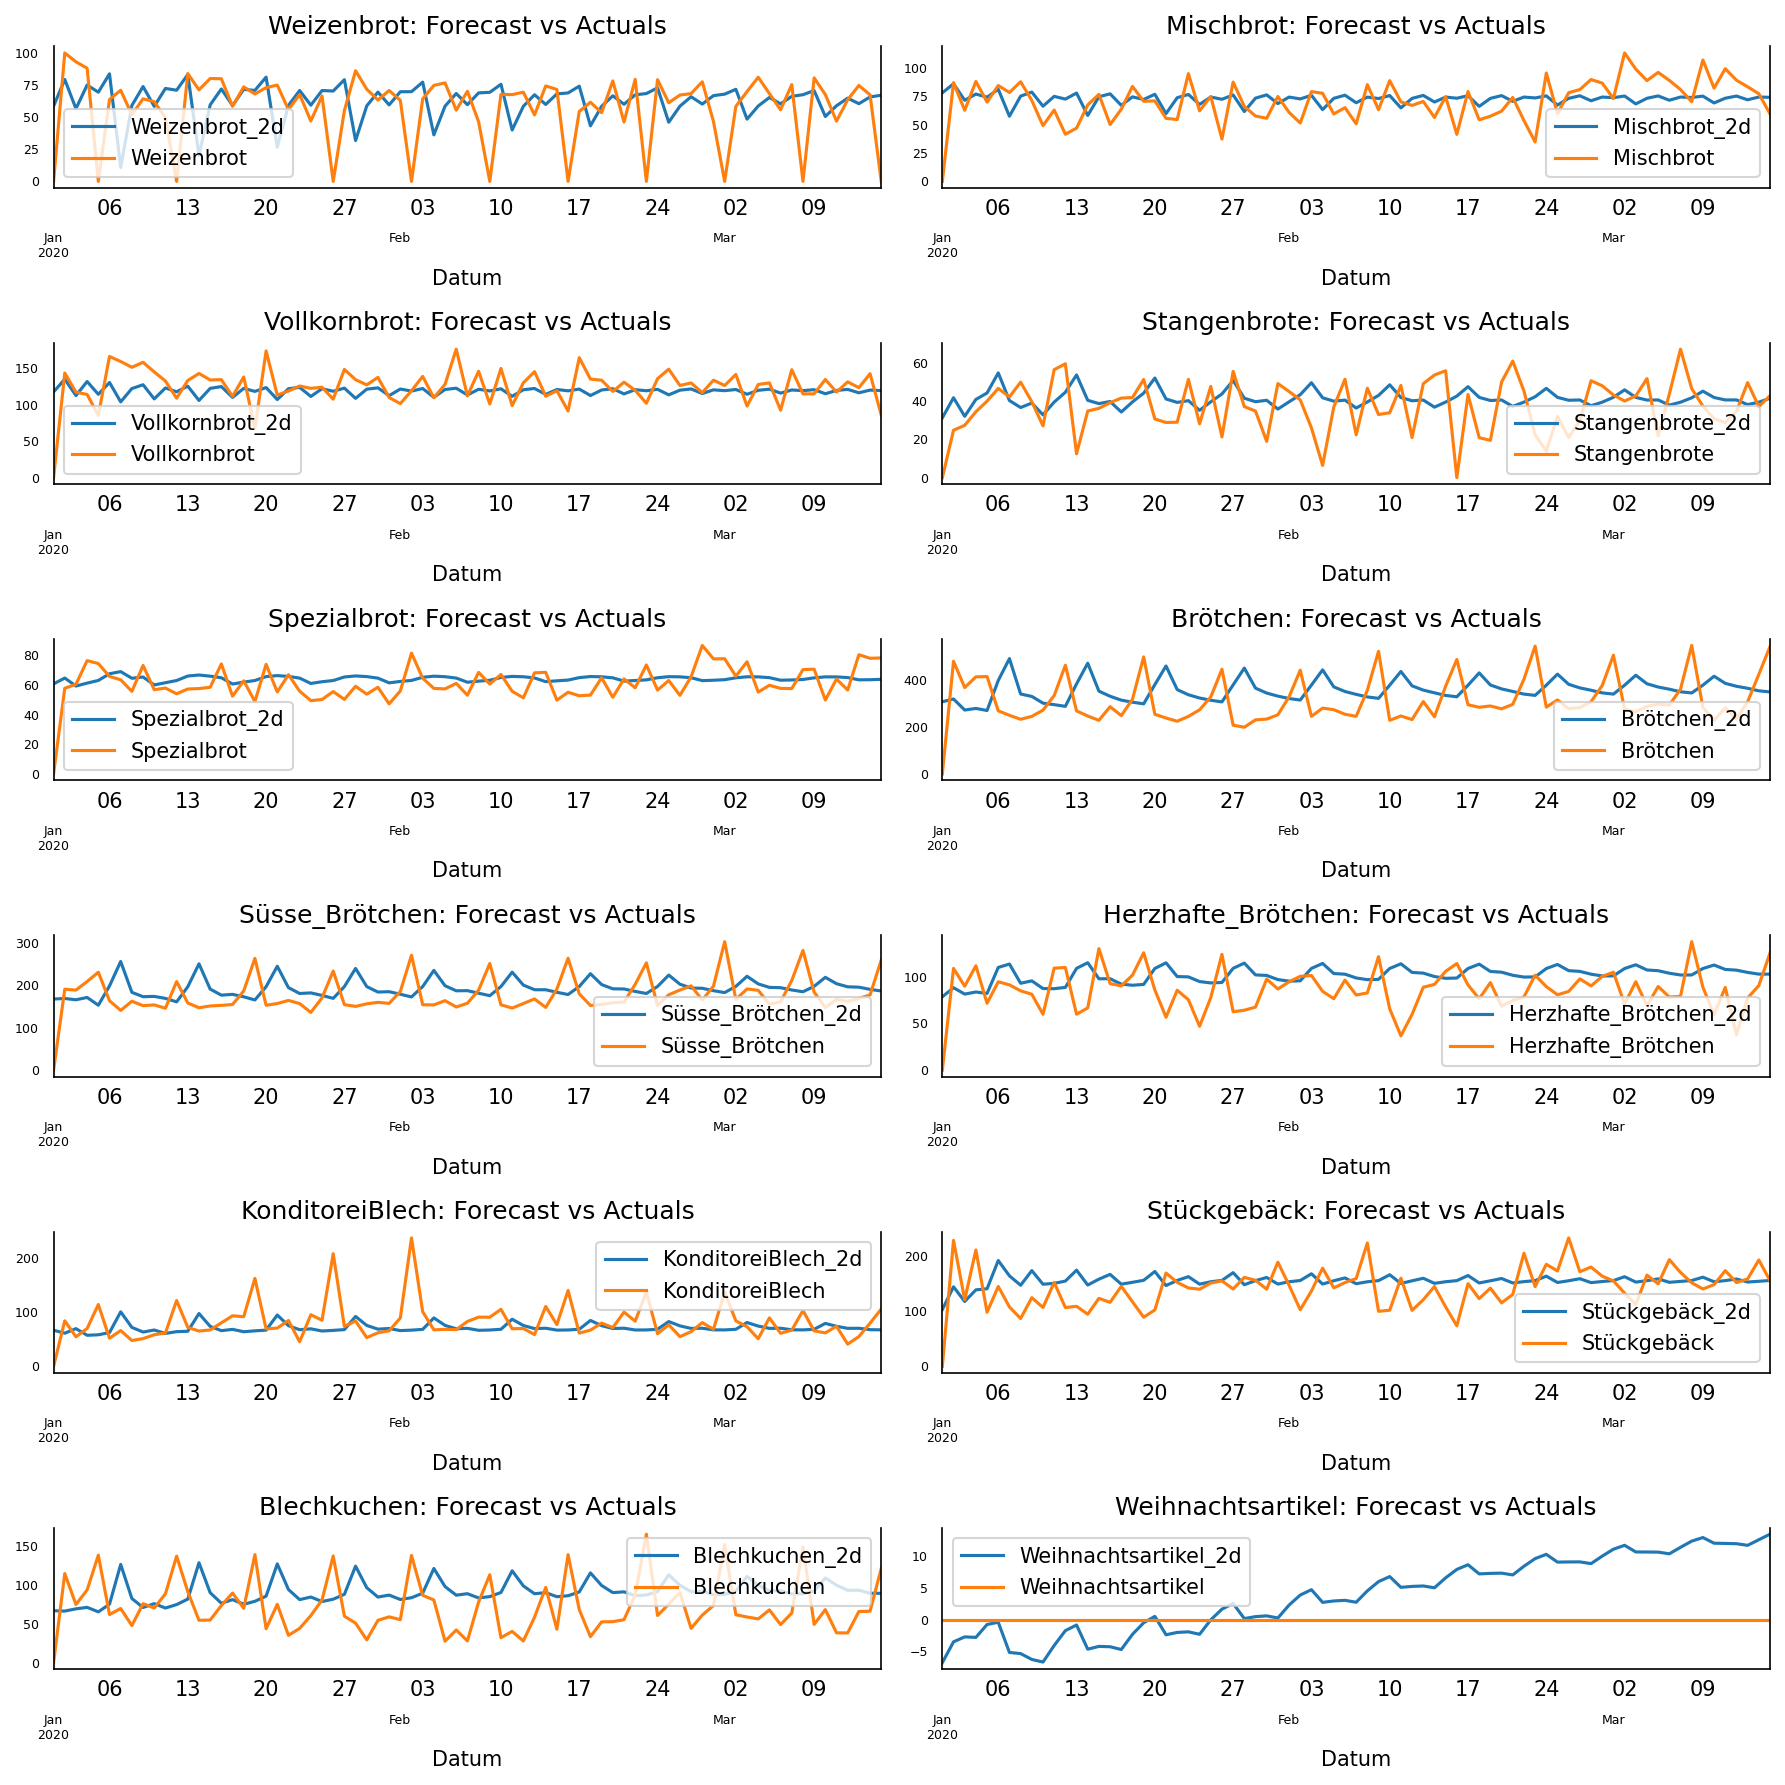

In [872]:
fig, axes = plt.subplots(nrows=int(len(df_basis_2_short.columns)/2), ncols=2, dpi=150, figsize=(12,12))
for i, (col,ax) in enumerate(zip(df_basis_2_short.columns, axes.flatten())):
    df_2_forecast[col+'_2d'].plot(legend=True, ax=ax)
    #.autoscale(axis='x',tight=True)
    test_short_2[col][-75:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [873]:
test_basis_2.shape

(440, 27)

#### Evaluate the Forecasts

In [874]:
df_results_VARMA = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE','CORR'])

In [875]:
article_selection=df_newmodel_2.iloc[:,0:12].columns.tolist()

In [876]:
for article in article_selection:
   name=article+ "_2d"
   #print(f'Forecast Accuracy of {article}:')
   accuracy_prod = forecast_accuracy(df_2_forecast[name].values, test_short_2[article])
   MAPE=mean_absolute_percentage_error(df_2_forecast[name].values, test_short_2[article])
   MAE=  mean_absolute_error(df_2_forecast[name].values, test_short_2[article])
   CORR = np.corrcoef(df_2_forecast[name].values, test_short_2[article])[0,1]                          
   df_results_VARMA=df_results_VARMA.append({'Model' : 'VARMA-7' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE,'CORR':CORR} , ignore_index=True)
   #print(accuracy_prod)                                 

In [877]:
df_results_VARMA.sort_values('Label')

Model               Label         MAE        MAPE      CORR
10  VARMA-7         Blechkuchen   38.243270   42.092255 -0.276043
5   VARMA-7            Brötchen  115.641380   32.178726 -0.409076
7   VARMA-7  Herzhafte_Brötchen   24.412141   23.923958 -0.181476
8   VARMA-7     KonditoreiBlech   24.350912   35.376278 -0.197001
1   VARMA-7           Mischbrot   14.048757   19.311392  0.121733
4   VARMA-7         Spezialbrot    9.067489   14.243838  0.131183
3   VARMA-7        Stangenbrote   11.956672   29.061400 -0.041965
9   VARMA-7         Stückgebäck   30.996205   20.351968  0.126094
6   VARMA-7      Süsse_Brötchen   44.190570   22.925381 -0.301444
2   VARMA-7        Vollkornbrot   17.806155   15.079488  0.226553
11  VARMA-7   Weihnachtsartikel    5.958371  100.000000       NaN
0   VARMA-7          Weizenbrot   22.652845   46.617052 -0.169411

### With Differencing

#### Modify data before Fitting

**Conclusions**
- `For differencing i need to modify the dataframe dor the closed days.`

In [815]:
# Copy the dataframe and replace the 0 Werte with NaN
train_short_2_mod=train_short_2.copy()

for i in train_short_2_mod.columns:
    train_short_2_mod[i]=train_short_2[i].apply(lambda x: x if x> 0 else None)

In [816]:
# Use combination of ffill and bfill to fill the missing values
train_short_2_mod.fillna(method="ffill",inplace=True)
train_short_2_mod.fillna(method="bfill",inplace=True)

In [817]:
# Checking NaN values
nan = pd.DataFrame(train_short_2_mod.isnull().sum(),columns=['Count'])
print(nan[nan.Count!=0])

Empty DataFrame
Columns: [Count]
Index: []


#### Fitting

In [818]:
model_diff = VAR(train_short_2.diff().dropna())
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  77.37980411044468
BIC :  78.28972635670328
FPE :  4.0330780367464144e+33
HQIC:  77.72927281614159 

Lag Order = 2
AIC :  77.02684454340417
BIC :  78.77840919369561
FPE :  2.834251920759197e+33
HQIC:  77.69959765305427 

Lag Order = 3
AIC :  76.78901789575058
BIC :  79.38387602778641
FPE :  2.23557033383449e+33
HQIC:  77.78572768017655 

Lag Order = 4
AIC :  76.81981707691125
BIC :  80.25962511296143
FPE :  2.3079150022380384e+33
HQIC:  78.14115803623994 

Lag Order = 5
AIC :  76.62904834844092
BIC :  80.91546807925707
FPE :  1.910374471830858e+33
HQIC:  78.27569722220589 

Lag Order = 6
AIC :  76.44906796603601
BIC :  81.58376657491118
FPE :  1.599821211332765e+33
HQIC:  78.421703743338 

Lag Order = 7
AIC :  75.51907823771269
BIC :  81.5037283246786
FPE :  6.33499894181742e+32
HQIC:  77.81838216743856 

Lag Order = 8
AIC :  75.51887875135971
BIC :  82.35515835752258
FPE :  6.364320567376063e+32
HQIC:  78.1455343524602 

Lag Order = 9
AIC :  75.63305554836383
BIC :

In [819]:
x = model_diff.select_order(maxlags=10)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [820]:
model_fitted_diff = model_diff.fit(7)
model_fitted_diff.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Nov, 2020
Time:                     15:40:27
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    82.9410
Nobs:                     722.000    HQIC:                   78.9665
Log likelihood:          -38878.6    FPE:                1.64154e+33
AIC:                      76.4678    Det(Omega_mle):     4.31733e+32
--------------------------------------------------------------------
Results for equation Weizenbrot
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.035582         0.721323            0.049           0.961
L1.Weizenbrot                -0.871518         0.046299          -18.824           0.000
L1.Mischbrot           

#### Check for serial correlation

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. 

- **The closer it is to the value 2**, then there is no significant serial correlation. 
- The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [821]:
from statsmodels.stats.stattools import durbin_watson

In [822]:
out = durbin_watson(model_fitted_diff.resid)

In [823]:
for col, val in zip(df_basis_2_short.columns, out):
    print((col), ':', round(val, 2))

Weizenbrot : 2.02
Mischbrot : 2.02
Vollkornbrot : 2.02
Stangenbrote : 2.02
Spezialbrot : 2.02
Brötchen : 2.02
Süsse_Brötchen : 2.02
Herzhafte_Brötchen : 1.99
KonditoreiBlech : 2.0
Stückgebäck : 1.88
Blechkuchen : 2.0
Weihnachtsartikel : 1.98


#### Prediction

In [824]:
# Get the lag order
lag_order = model_fitted_diff.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_basis_2_short.values[-lag_order:]
forecast_input

7


array([[ 80.59449783, 106.8095961 , 114.79787247,  37.34639658,
         70.59203081, 283.36829163, 183.84769634,  88.65728713,
         65.34406876, 140.03395067,  49.10265873,   0.        ],
       [ 67.63689306,  82.05005118, 134.50052538,  30.81310065,
         49.75556409, 227.92223776, 147.39400308,  59.23690467,
         61.68896942, 147.88312898,  68.04965402,   0.        ],
       [ 46.92076429,  99.15307209, 117.20253083,  28.69874937,
         63.9437767 , 281.69362459, 166.8771371 ,  88.43091063,
         73.79783324, 173.16787735,  38.30100648,   0.        ],
       [ 63.59541971,  89.04599385, 131.219099  ,  34.60037447,
         56.52196075, 234.38021086, 162.05366999,  37.60805815,
         40.98855303, 151.60500767,  38.11128329,   0.        ],
       [ 74.70615962,  83.23887852, 123.21363338,  49.61986497,
         80.33457397, 307.61961848, 169.03098363,  77.11969619,
         54.89467198, 158.1998222 ,  65.65013934,   0.        ],
       [ 67.40654152,  77.16505115,

In [578]:
len(test_short_2)

75

In [825]:
# Forecast
fc = model_fitted_diff.forecast(y=forecast_input, steps=75)
df_2_forecast_diff = pd.DataFrame(fc, index=df_basis_2_short.index[-75:], columns=df_basis_2_short.columns + '_1d')
df_2_forecast_diff.tail(5)

Weizenbrot_1d  Mischbrot_1d  Vollkornbrot_1d  Stangenbrote_1d  \
Datum                                                                       
2020-03-11      11.105175      3.971844         3.833568        -0.850395   
2020-03-12       9.157674      2.808035         2.406821         3.110411   
2020-03-13      -8.191664     -4.566945        -5.259055        -0.097309   
2020-03-14      -1.523115      0.779693         2.267893         1.001130   
2020-03-15      -0.205946      0.389206         0.802892         0.534974   

            Spezialbrot_1d  Brötchen_1d  Süsse_Brötchen_1d  \
Datum                                                        
2020-03-11       -0.727429   -47.122024         -22.253281   
2020-03-12       -0.004923    -7.741245          -6.630742   
2020-03-13       -0.485209    22.048876          11.878504   
2020-03-14        1.068234    14.490122           6.831049   
2020-03-15        0.865965    -1.521345          -2.169074   

            Herzhafte_Brötchen_1d  KonditoreiBlech_1d  Stückgebäck_1d  \
Datum                                                                   
2020-03-11              -7.840785           -6.994460        1.646256   
2020-03-12               1.431818           -4.334596        5.568429   
2020-03-13               2.786749            3.801678       -3.317569   
2020-03-14               1.559731            2.377776        2.060541   
2020-03-15               0.481403            0.296888        2.233532   

            Blechkuchen_1d  Weihnachtsartikel_1d  
Datum                                             
2020-03-11      -12.239891              0.570111  
2020-03-12       -6.972204              0.745884  
2020-03-13        7.442938             -0.128131  
2020-03-14        4.079495              0.282609  
2020-03-15        0.550490             -0.086390

#### Invert the Prediction to get the real Value

In [860]:
def invert_transformation(nobs,df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
    
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1-nobs] + df_fc[str(col)+'_1d'].cumsum().fillna(0)
    return df_fc

In [861]:
df_2_results = invert_transformation(0,train_short_2, df_2_forecast_diff)  


In [862]:
test_short_2['Brötchen']

Datum
2020-01-01      0.000000
2020-01-02    480.125014
2020-01-03    368.181023
2020-01-04    413.694884
2020-01-05    414.865379
                 ...    
2020-03-11    281.693625
2020-03-12    234.380211
2020-03-13    307.619618
2020-03-14    424.131843
2020-03-15    542.648827
Name: Brötchen, Length: 75, dtype: float64

In [863]:
train_short_2['Brötchen'].iloc[-1]+df_2_forecast_diff.Brötchen_1d.cumsum()

Datum
2020-01-01   -632.036375
2020-01-02   -457.896758
2020-01-03   -407.351123
2020-01-04   -345.861562
2020-01-05   -348.071531
                 ...    
2020-03-11   -261.627754
2020-03-12   -269.368999
2020-03-13   -247.320123
2020-03-14   -232.830001
2020-03-15   -234.351346
Name: Brötchen_1d, Length: 75, dtype: float64

In [864]:
df_2_results['Brötchen_forecast']

Datum
2020-01-01   -632.036375
2020-01-02   -457.896758
2020-01-03   -407.351123
2020-01-04   -345.861562
2020-01-05   -348.071531
                 ...    
2020-03-11   -261.627754
2020-03-12   -269.368999
2020-03-13   -247.320123
2020-03-14   -232.830001
2020-03-15   -234.351346
Name: Brötchen_forecast, Length: 75, dtype: float64

#### Plotting

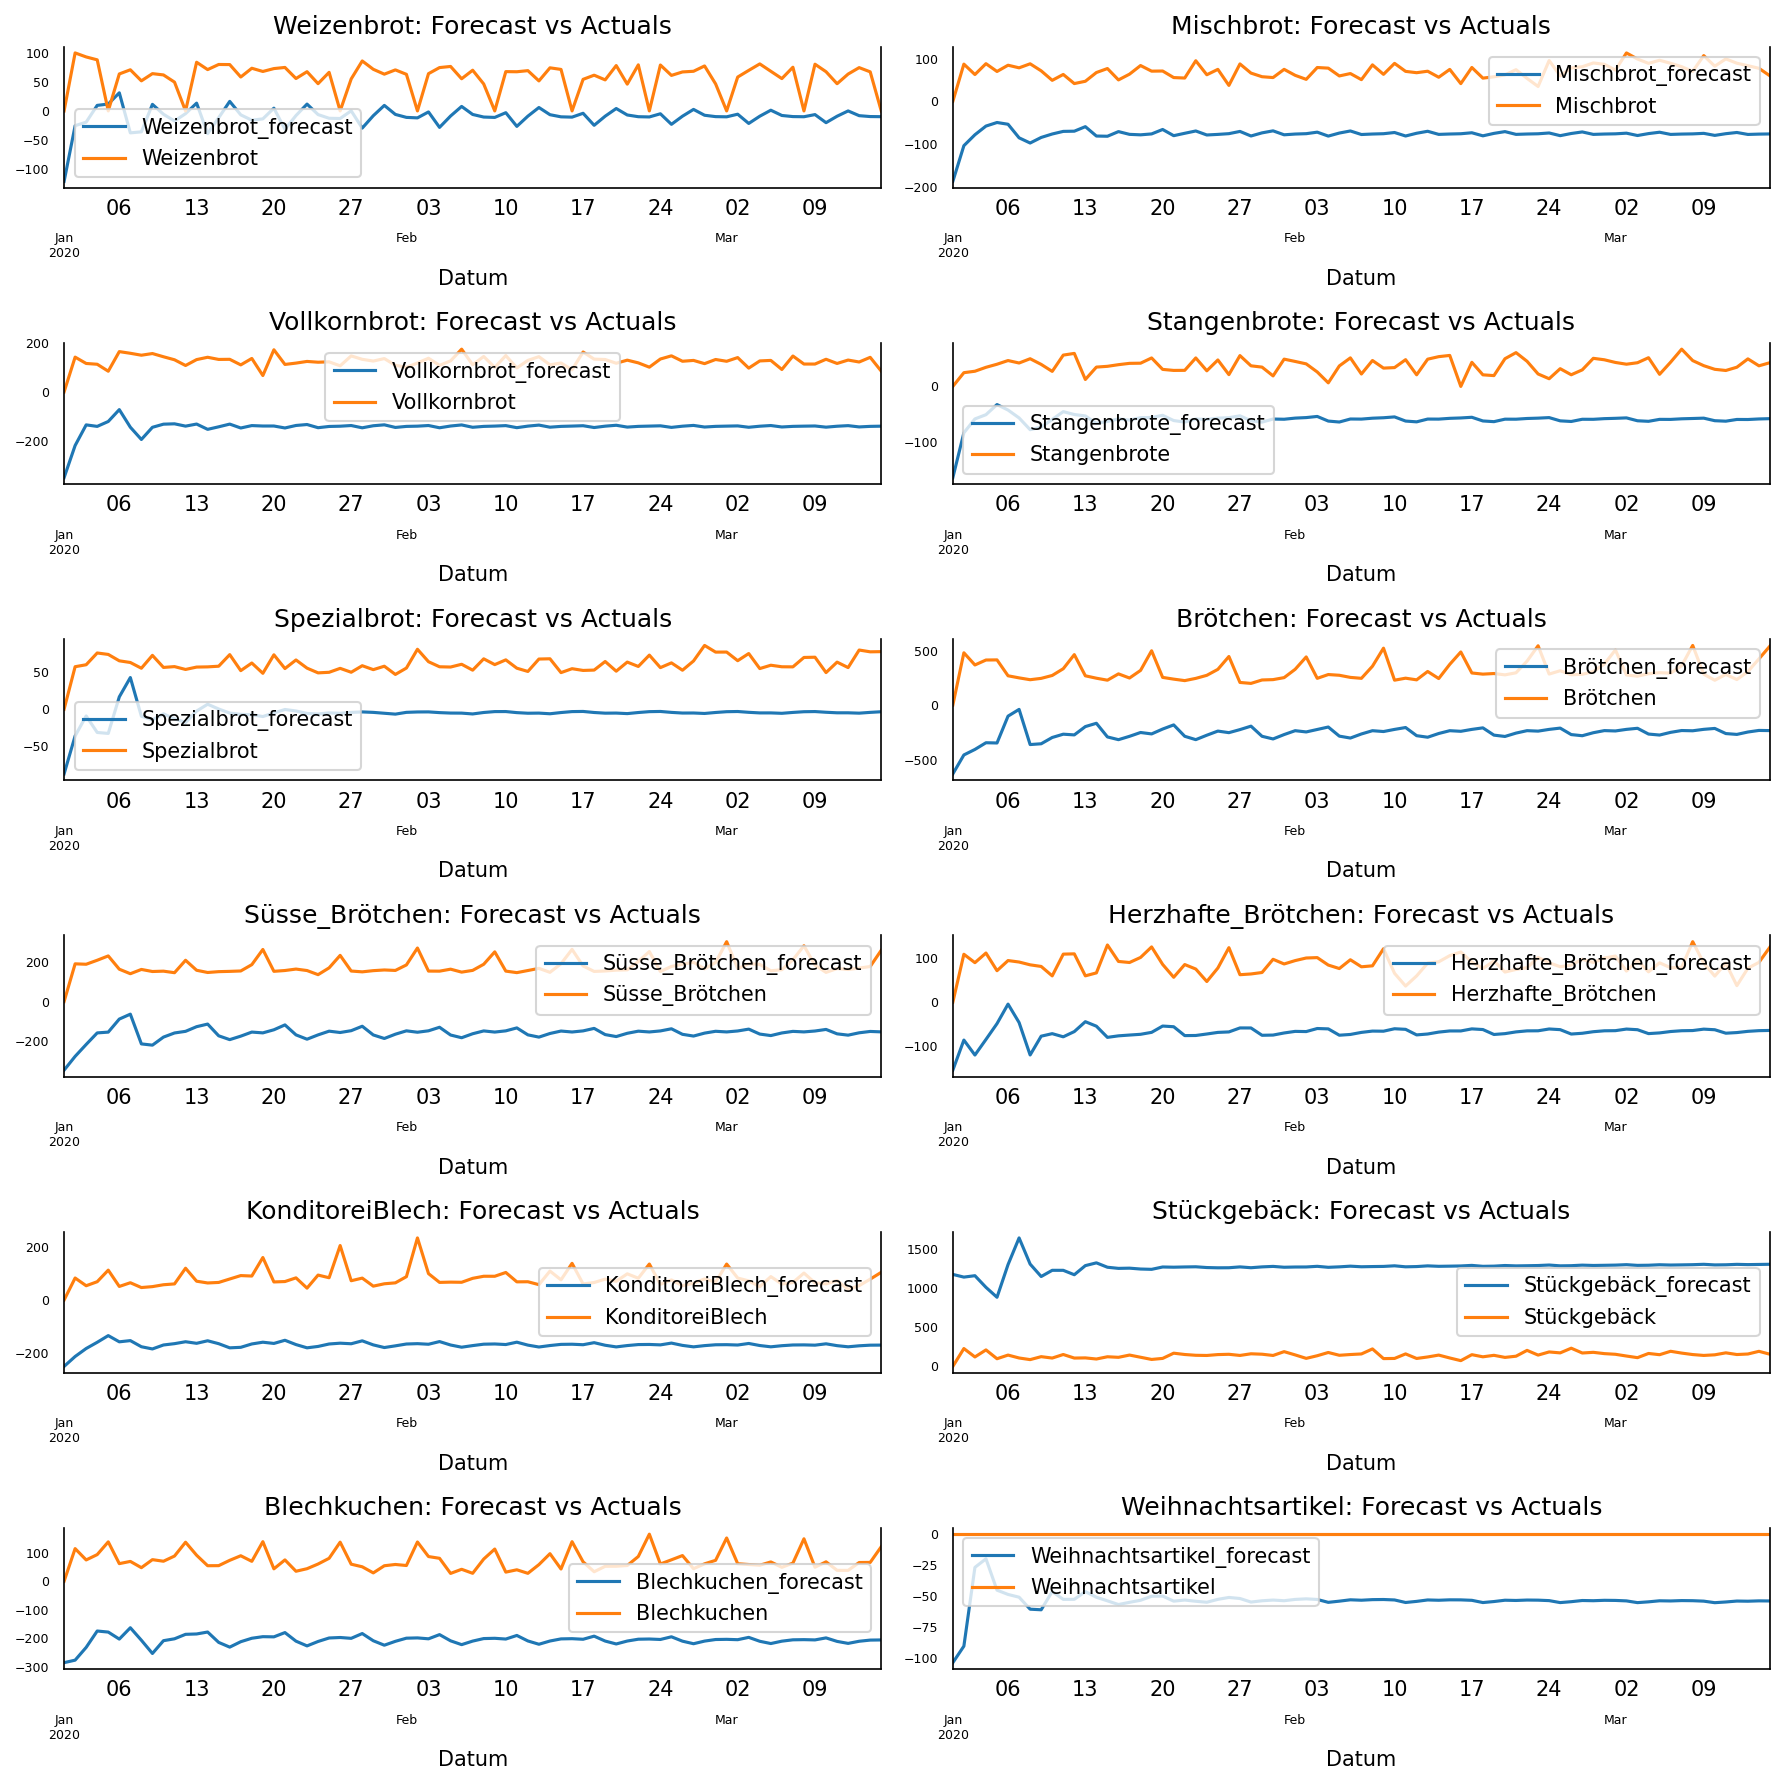

In [865]:
fig, axes = plt.subplots(nrows=int(len(df_basis_2_short.columns)/2), ncols=2, dpi=150, figsize=(12,12))
for i, (col,ax) in enumerate(zip(df_basis_2_short.columns, axes.flatten())):
    df_2_results[col+'_forecast'].plot(legend=True, ax=ax)
    #.autoscale(axis='x',tight=True)
    test_short_2[col][-75:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
test_basis_2.shape

#### Evaluate the Forecasts

In [694]:
df_results_VARMA = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE','CORR'])

In [539]:
article_selection=df_newmodel_2.iloc[:,0:12].columns.tolist()

In [695]:
for article in article_selection:
   name=article+ "_forecast"
   #print(f'Forecast Accuracy of {article}:')
   accuracy_prod = forecast_accuracy(df_2_results[name].values, test_short_2[article])
   MAPE=mean_absolute_percentage_error(df_2_results[name].values, test_short_2[article])
   MAE=  mean_absolute_error(df_2_results[name].values, test_short_2[article])
   CORR = np.corrcoef(df_2_results[name].values, test_short_2[article])[0,1]                          
   df_results_VARMA=df_results_VARMA.append({'Model' : 'VARMA-7-diff' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE,'CORR':CORR} , ignore_index=True)
   #print(accuracy_prod)                                 

In [696]:
df_results_VARMA.sort_values('Label')

Model               Label          MAE         MAPE      CORR
10  VARMA-7-diff         Blechkuchen   328.939744   127.623776 -0.380204
5   VARMA-7-diff            Brötchen   184.034044    37.626658 -0.518502
7   VARMA-7-diff  Herzhafte_Brötchen    27.262629    45.686815 -0.300000
8   VARMA-7-diff     KonditoreiBlech   153.649834   212.533281 -0.078672
1   VARMA-7-diff           Mischbrot   103.776456   321.749212  0.304119
4   VARMA-7-diff         Spezialbrot    24.835115   129.990549  0.251502
3   VARMA-7-diff        Stangenbrote    46.387409  2400.442782 -0.247880
9   VARMA-7-diff         Stückgebäck  1512.336195    91.375389 -0.002998
6   VARMA-7-diff      Süsse_Brötchen   138.019173  1334.109364 -0.552189
2   VARMA-7-diff        Vollkornbrot   239.227694   211.121557  0.466759
11  VARMA-7-diff   Weihnachtsartikel    85.485607   100.000000       NaN
0   VARMA-7-diff          Weizenbrot    53.213745   972.801401  0.162752

## Long Period

### Without Differencing

In [901]:
# I remove Weihnachtsartikel
train_basis_2_col=train_basis_2.iloc[:,0:11]
test_basis_2_col=test_basis_2.iloc[:,0:11]
df_basis_2_col=df_basis_2.iloc[:,0:11]

#### Fitting

In [902]:
model_long = VAR(df_basis_2_col)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  73.63272194686256
BIC :  74.23528201332564
FPE :  9.512376273928682e+31
HQIC:  73.86072565972852 

Lag Order = 2
AIC :  73.23989340175616
BIC :  74.39564457515144
FPE :  6.42260424993648e+31
HQIC:  73.6772395895878 

Lag Order = 3
AIC :  73.07044763713635
BIC :  74.78019958277041
FPE :  5.422357157765439e+31
HQIC:  73.7174614529827 

Lag Order = 4
AIC :  73.03453099936424
BIC :  75.29909532845848
FPE :  5.232592335065787e+31
HQIC:  73.89153839857926 

Lag Order = 5
AIC :  72.91859757850904
BIC :  75.7387878546531
FPE :  4.662039397538775e+31
HQIC:  73.98592532145275 

Lag Order = 6
AIC :  72.6552066405085
BIC :  76.03183838614105
FPE :  3.5850619469059778e+31
HQIC:  73.93318229525964 

Lag Order = 7
AIC :  71.77482284655919
BIC :  75.70871354947606
FPE :  1.487933037790056e+31
HQIC:  73.2637747916395 

Lag Order = 8
AIC :  71.74846924747789
BIC :  76.24043836736773
FPE :  1.451157663412548e+31
HQIC:  73.44872667458795 

Lag Order = 9
AIC :  71.81672271784463
BIC : 

In [903]:
x = model_long.select_order(maxlags=10)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [918]:
model_fitted = model_long.fit(28)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Nov, 2020
Time:                     13:29:59
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    84.3856
Nobs:                     1508.00    HQIC:                   76.8624
Log likelihood:          -74726.2    FPE:                2.95141e+31
AIC:                      72.3977    Det(Omega_mle):     3.79787e+30
--------------------------------------------------------------------
Results for equation Weizenbrot
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         80.242163        14.689822            5.462           0.000
L1.Weizenbrot                 -0.045139         0.034230           -1.319           0.187
L1.Mischbrot       

#### Check for serial correlation

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. 

- **The closer it is to the value 2**, then there is no significant serial correlation. 
- The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [919]:
from statsmodels.stats.stattools import durbin_watson

In [920]:
out = durbin_watson(model_fitted.resid)

In [921]:
for col, val in zip(df_basis_2_col, out):
    print((col), ':', round(val, 2))

Weizenbrot : 2.0
Mischbrot : 1.99
Vollkornbrot : 2.0
Stangenbrote : 1.99
Spezialbrot : 2.0
Brötchen : 2.0
Süsse_Brötchen : 2.0
Herzhafte_Brötchen : 2.0
KonditoreiBlech : 2.0
Stückgebäck : 2.0
Blechkuchen : 1.99


#### Prediction

In [922]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_basis_2_col.values[-lag_order:]
forecast_input

28


array([[ 54.47876279,  79.07680916, 164.33313984,  43.4228914 ,
         52.65938263, 294.76749519, 179.84300778,  91.0575032 ,
         61.26537398, 149.68196303,  68.0233496 ],
       [ 61.64920695,  54.21240474, 135.01918955,  20.87362681,
         53.14820439, 284.04702177, 152.23005641,  76.30210625,
         66.73880795, 122.50689609,  33.33216937],
       [ 53.53355377,  57.3692978 , 133.42196423,  19.47518013,
         64.78921291, 289.62151634, 154.62295417,  93.57250761,
         79.684378  , 141.47948023,  52.3818702 ],
       [ 78.24948935,  61.80699049, 118.07673237,  49.90506085,
         51.65366061, 277.36162306, 158.78128699,  68.39274644,
         71.43250841, 114.92341518,  52.59395745],
       [ 46.19923577,  73.90032891, 130.80039192,  60.883197  ,
         63.99712532, 296.46237425, 160.27716607,  74.36796145,
         99.82163148, 130.15577975,  55.13056636],
       [ 79.48080197,  53.56939368, 119.61621998,  45.25344912,
         58.04851933, 403.52159838, 201.9

In [923]:
len(test_basis_2_col)

440

In [924]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=440)
df_2_long_forecast = pd.DataFrame(fc, index=df_basis_2_col.index[-440:], columns=df_basis_2_col.columns + '_2d')
df_2_long_forecast.tail(5)

Weizenbrot_2d  Mischbrot_2d  Vollkornbrot_2d  Stangenbrote_2d  \
Datum                                                                       
2020-03-11      62.941117     74.143409       114.739936        37.572117   
2020-03-12      63.416419     73.367536       112.734127        36.408145   
2020-03-13      70.804238     76.999358       117.387737        40.380646   
2020-03-14      68.606355     74.540471       114.980712        43.162397   
2020-03-15      65.865542     73.767825       115.618918        45.053509   

            Spezialbrot_2d  Brötchen_2d  Süsse_Brötchen_2d  \
Datum                                                        
2020-03-11       62.839843   377.009442         198.342107   
2020-03-12       61.652114   357.710965         190.942402   
2020-03-13       62.340628   353.342193         186.789213   
2020-03-14       63.896514   368.170883         192.748873   
2020-03-15       65.842055   414.858889         213.140688   

            Herzhafte_Brötchen_2d  KonditoreiBlech_2d  Stückgebäck_2d  \
Datum                                                                   
2020-03-11             103.530352           83.133662      152.816986   
2020-03-12             100.123113           80.662215      147.445403   
2020-03-13             100.144169           78.558499      150.358319   
2020-03-14             102.795668           78.889145      153.105068   
2020-03-15             108.612399           86.309277      161.049329   

            Blechkuchen_2d  
Datum                       
2020-03-11       93.066587  
2020-03-12       89.969165  
2020-03-13       86.764773  
2020-03-14       91.936922  
2020-03-15      101.926569

#### Plotting

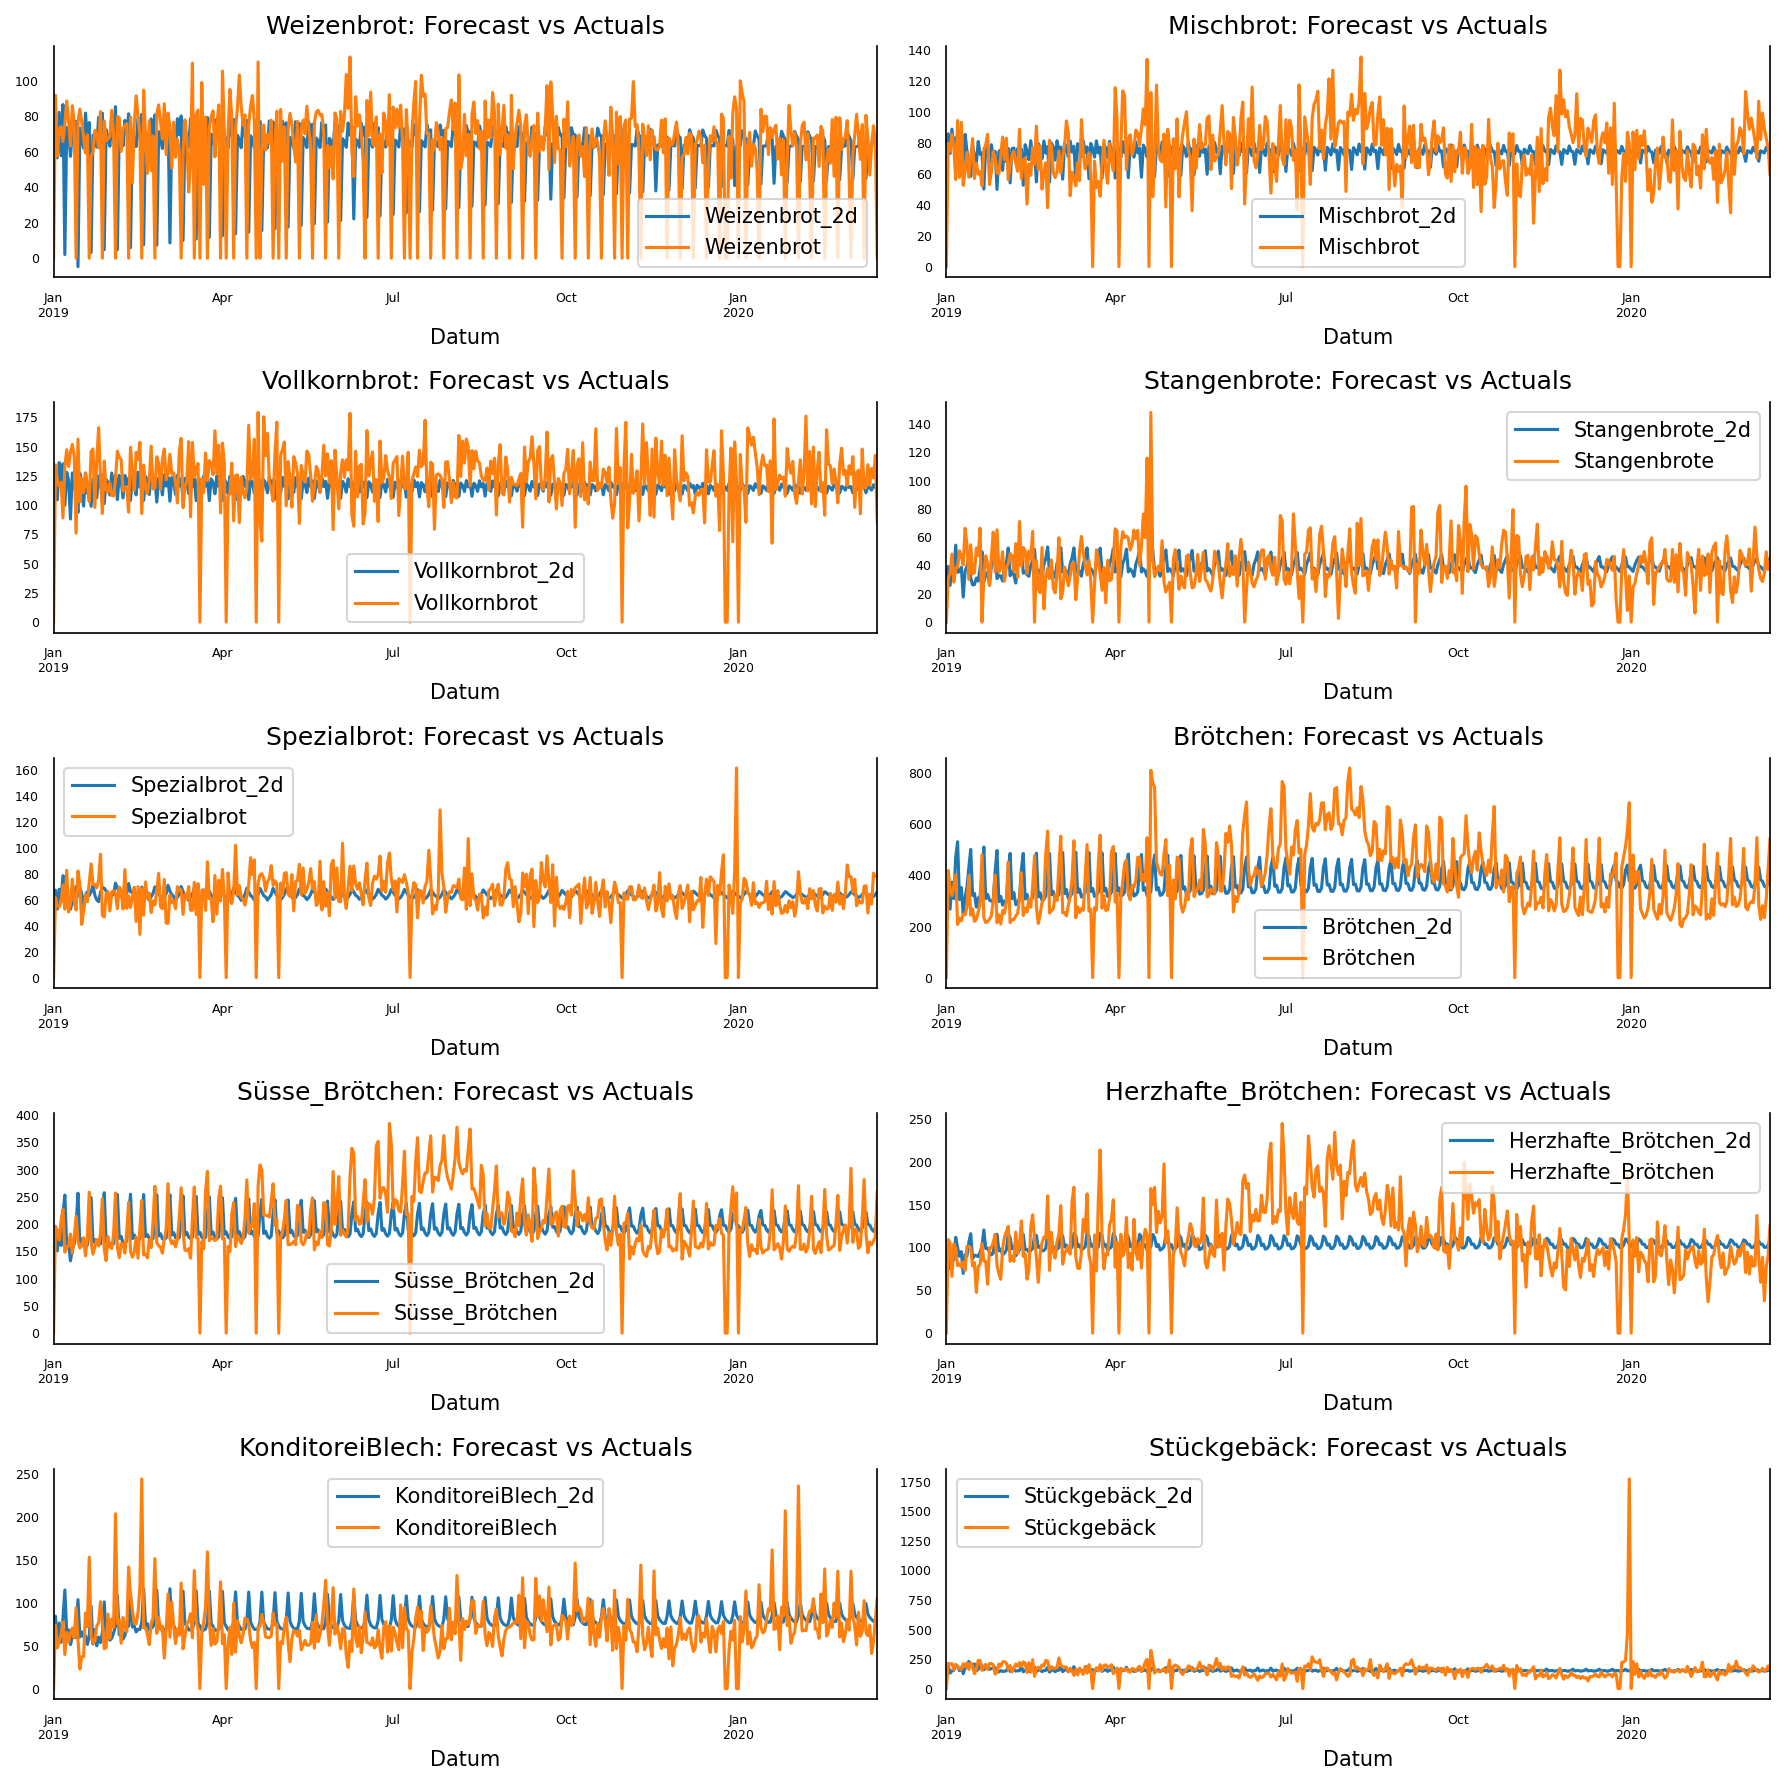

In [925]:
fig, axes = plt.subplots(nrows=int(len(df_basis_2_col.columns)/2), ncols=2, dpi=150, figsize=(12,12))
for i, (col,ax) in enumerate(zip(df_basis_2_col.columns, axes.flatten())):
    df_2_long_forecast[col+'_2d'].plot(legend=True, ax=ax)
    #.autoscale(axis='x',tight=True)
    test_basis_2_col[col][-440:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### Evaluate the Forecasts

In [874]:
df_results_VARMA = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE','CORR'])

In [912]:
article_selection=df_basis_2_col.columns.tolist()

In [926]:
for article in article_selection:
   name=article+ "_2d"
   #print(f'Forecast Accuracy of {article}:')
   accuracy_prod = forecast_accuracy(df_2_long_forecast[name].values, test_basis_2_col[article])
   MAPE=mean_absolute_percentage_error(df_2_long_forecast[name].values, test_basis_2_col[article])
   MAE=  mean_absolute_error(df_2_long_forecast[name].values, test_basis_2_col[article])
   CORR = np.corrcoef(df_2_long_forecast[name].values, test_basis_2_col[article])[0,1]                          
   df_results_VARMA=df_results_VARMA.append({'Model' : 'VARMA-28-long' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE,'CORR':CORR} , ignore_index=True)
   #print(accuracy_prod)                                 

In [928]:
df_results_VARMA.query('Model=="VARMA-28-long"').sort_values('Label')

Model               Label         MAE       MAPE      CORR
33  VARMA-28-long         Blechkuchen   37.065610  40.161544  0.077186
28  VARMA-28-long            Brötchen  115.798833  30.716290  0.173519
30  VARMA-28-long  Herzhafte_Brötchen   30.267954  29.293641  0.188572
31  VARMA-28-long     KonditoreiBlech   23.571854  28.860966  0.037041
24  VARMA-28-long           Mischbrot   17.390228  24.059806 -0.140923
27  VARMA-28-long         Spezialbrot   11.428301  17.996767  0.080725
26  VARMA-28-long        Stangenbrote   13.311750  34.069262  0.068060
32  VARMA-28-long         Stückgebäck   40.904204  26.419514  0.002133
29  VARMA-28-long      Süsse_Brötchen   45.056058  22.667177  0.179943
25  VARMA-28-long        Vollkornbrot   22.163001  19.416847 -0.204945
23  VARMA-28-long          Weizenbrot   25.392433  81.803024 -0.256188

In [ ]:
model = VARMAX(train, order=(1,2), trend='c')


# VARMAX - Filiale 2

**Conclusions**
- `A`

In [112]:
# I remove Weihnachtsartikel
train_basis_2_col=train_basis_2.iloc[:,0:11]
test_basis_2_col=test_basis_2.iloc[:,0:11]
df_basis_2_col=df_basis_2.iloc[:,0:11]

In [ ]:
exog_train
exog_test

In [114]:
train_basis_2_col.shape

(1096, 11)

In [115]:
exog_test.shape

(440, 32)

## Fitting

In [116]:
model_exog = VARMAX(train_basis_2_col,order=(7,0),exog=exog_train)

In [938]:
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_exog.fit(order=(i,0))
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    #print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 2
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 3
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 4
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 5
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 6
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 7
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 8
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 

Lag Order = 9
AIC :  113565.01070594863
BIC :  119944.27377448879
HQIC:  115978.76284580589 



In [117]:
model_fitted_exog = model_exog.fit(order=(7,0))
model_fitted_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                                                          Statespace Model Results                                                                                                         
===========================================================================================================================================================================================================================================
Dep. Variable:     ['Weizenbrot', 'Mischbrot', 'Vollkornbrot', 'Stangenbrote', 'Spezialbrot', 'Brötchen', 'Süsse_Brötchen', 'Herzhafte_Brötchen', 'KonditoreiBlech', 'Stückgebäck', 'Blechkuchen']   No. Observations:                 1096
Model:                                                                                                                                                                                     VARX(7)   Log Likelihood              -55516.055
                                                                                                                                                                                       + intercept   AIC                         113584.111
Date:                                                                                                                                                                             Wed, 25 Nov 2020   BIC                         119963.374
Time:                                                                                                                                                                                     10:03:42   HQIC                        115997.863
Sample:                                                                                                                                                                                 01-01-2016                                         
                                                                                                                                                                                      - 12-31-2018                                         
Covariance Type:                                                                                                                                                                               opg                                         
========================================================================================================================================================================================================
Ljung-Box (L1) (Q):     0.57, 0.00, 1.27, 0.42, 0.28, 4.04, 0.21, 0.04, 1.20, 0.08, 0.23   Jarque-Bera (JB):   710.86, 13.05, 602.25, 119.35, 471.78, 2153.51, 1850.49, 26.30, 229.06, 372829.32, 661.19
Prob(Q):                0.45, 0.96, 0.26, 0.52, 0.60, 0.04, 0.65, 0.84, 0.27, 0.78, 0.63   Prob(JB):                                    0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 0.69, 1.07, 0.97, 0.95, 0.42, 0.55, 0.67, 1.41, 0.21, 2.92, 1.00   Skew:                                   0.46, -0.23, 0.37, 0.22, -0.24, -0.72, -0.84, 0.02, -0.04, 6.32, 0.28
Prob(H) (two-sided):    0.00, 0.54, 0.75, 0.64, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.98   Kurtosis:                                   6.84, 3.28, 6.55, 4.56, 6.18, 9.72, 9.14, 3.76, 5.24, 92.47, 6.76
                             Results for equation Weizenbrot                             
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                42.8867      9.579      4.477      0.000      24.113      61.661
L1.Weizenbrot            -0.0006      0.153     -0.004      0.997      -0.301       0.299
L1.Mischbrot              0.0049      0.176    

## Check for serial correlation

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. 

- **The closer it is to the value 2**, then there is no significant serial correlation. 
- The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [519]:
from statsmodels.stats.stattools import durbin_watson

In [520]:
out = durbin_watson(model_fitted.resid)

In [521]:
for col, val in zip(df_basis_2_short.columns, out):
    print((col), ':', round(val, 2))

Weizenbrot : 1.97
Mischbrot : 2.07
Vollkornbrot : 2.01
Stangenbrote : 2.03
Spezialbrot : 2.01
Brötchen : 2.19
Süsse_Brötchen : 2.08
Herzhafte_Brötchen : 2.26
KonditoreiBlech : 2.07
Stückgebäck : 2.04
Blechkuchen : 2.2
Weihnachtsartikel : 2.41


## Prediction

In [524]:
len(test_short_2)

75

In [121]:
# Forecast targets
fc = model_fitted_exog.forecast(steps=440, exog=exog_test)

In [123]:
fc

Weizenbrot  Mischbrot  Vollkornbrot  Stangenbrote  Spezialbrot  \
2019-01-01   13.758864 -10.961070     20.606690    -11.685717    22.960160   
2019-01-02   74.650086  54.109109    120.349718     12.178921    78.025228   
2019-01-03   84.388133  52.068924    122.534866     34.397253    58.068149   
2019-01-04   67.224022  64.105859    121.351737     51.165387    59.450773   
2019-01-05   81.489516  79.230083     98.392772     60.117164    48.453692   
...                ...        ...           ...           ...          ...   
2020-03-11   74.193388  69.631632     98.398064     40.227154    36.456969   
2020-03-12   76.233710  74.734397    107.873368     48.141869    35.700576   
2020-03-13   74.772768  70.473192    103.572171     53.297105    39.376969   
2020-03-14   77.389007  68.942742    106.181878     56.436256    44.485565   
2020-03-15   12.162825  49.866582     91.701379     38.070699    37.608610   

              Brötchen  Süsse_Brötchen  Herzhafte_Brötchen  KonditoreiBlech  \
2019-01-01   39.570682       12.470694           22.230194         5.490837   
2019-01-02  330.275995      162.542574           89.913357       115.659070   
2019-01-03  294.204550      165.711502           82.206679       104.858197   
2019-01-04  277.938438      140.638381           70.415103       111.478876   
2019-01-05  328.029543      161.447043           87.262520       106.402099   
...                ...             ...                 ...              ...   
2020-03-11  301.109390      159.949171           81.033940       134.650563   
2020-03-12  306.952651      162.612270           77.953903       135.514381   
2020-03-13  317.069699      166.813120           80.465235       132.503760   
2020-03-14  391.037515      198.837761           87.001584       138.201602   
2020-03-15  434.756847      219.700236           80.149149       183.626281   

            Stückgebäck  Blechkuchen  
2019-01-01   303.582456   -58.653919  
2019-01-02   312.013478    35.923586  
2019-01-03   294.031416    23.343800  
2019-01-04   291.209449    62.593446  
2019-01-05   271.491188    71.068438  
...                 ...          ...  
2020-03-11   154.098054    53.965081  
2020-03-12   155.360249    57.205914  
2020-03-13   162.268057    66.363002  
2020-03-14   180.657821    79.614306  
2020-03-15   144.399292   107.776663  

[440 rows x 11 columns]

In [124]:
# Forecast
#df_2_forecast = pd.DataFrame(fc, index=df_basis_2_col.index[-440:], columns=df_basis_2_col.columns)


## Plotting

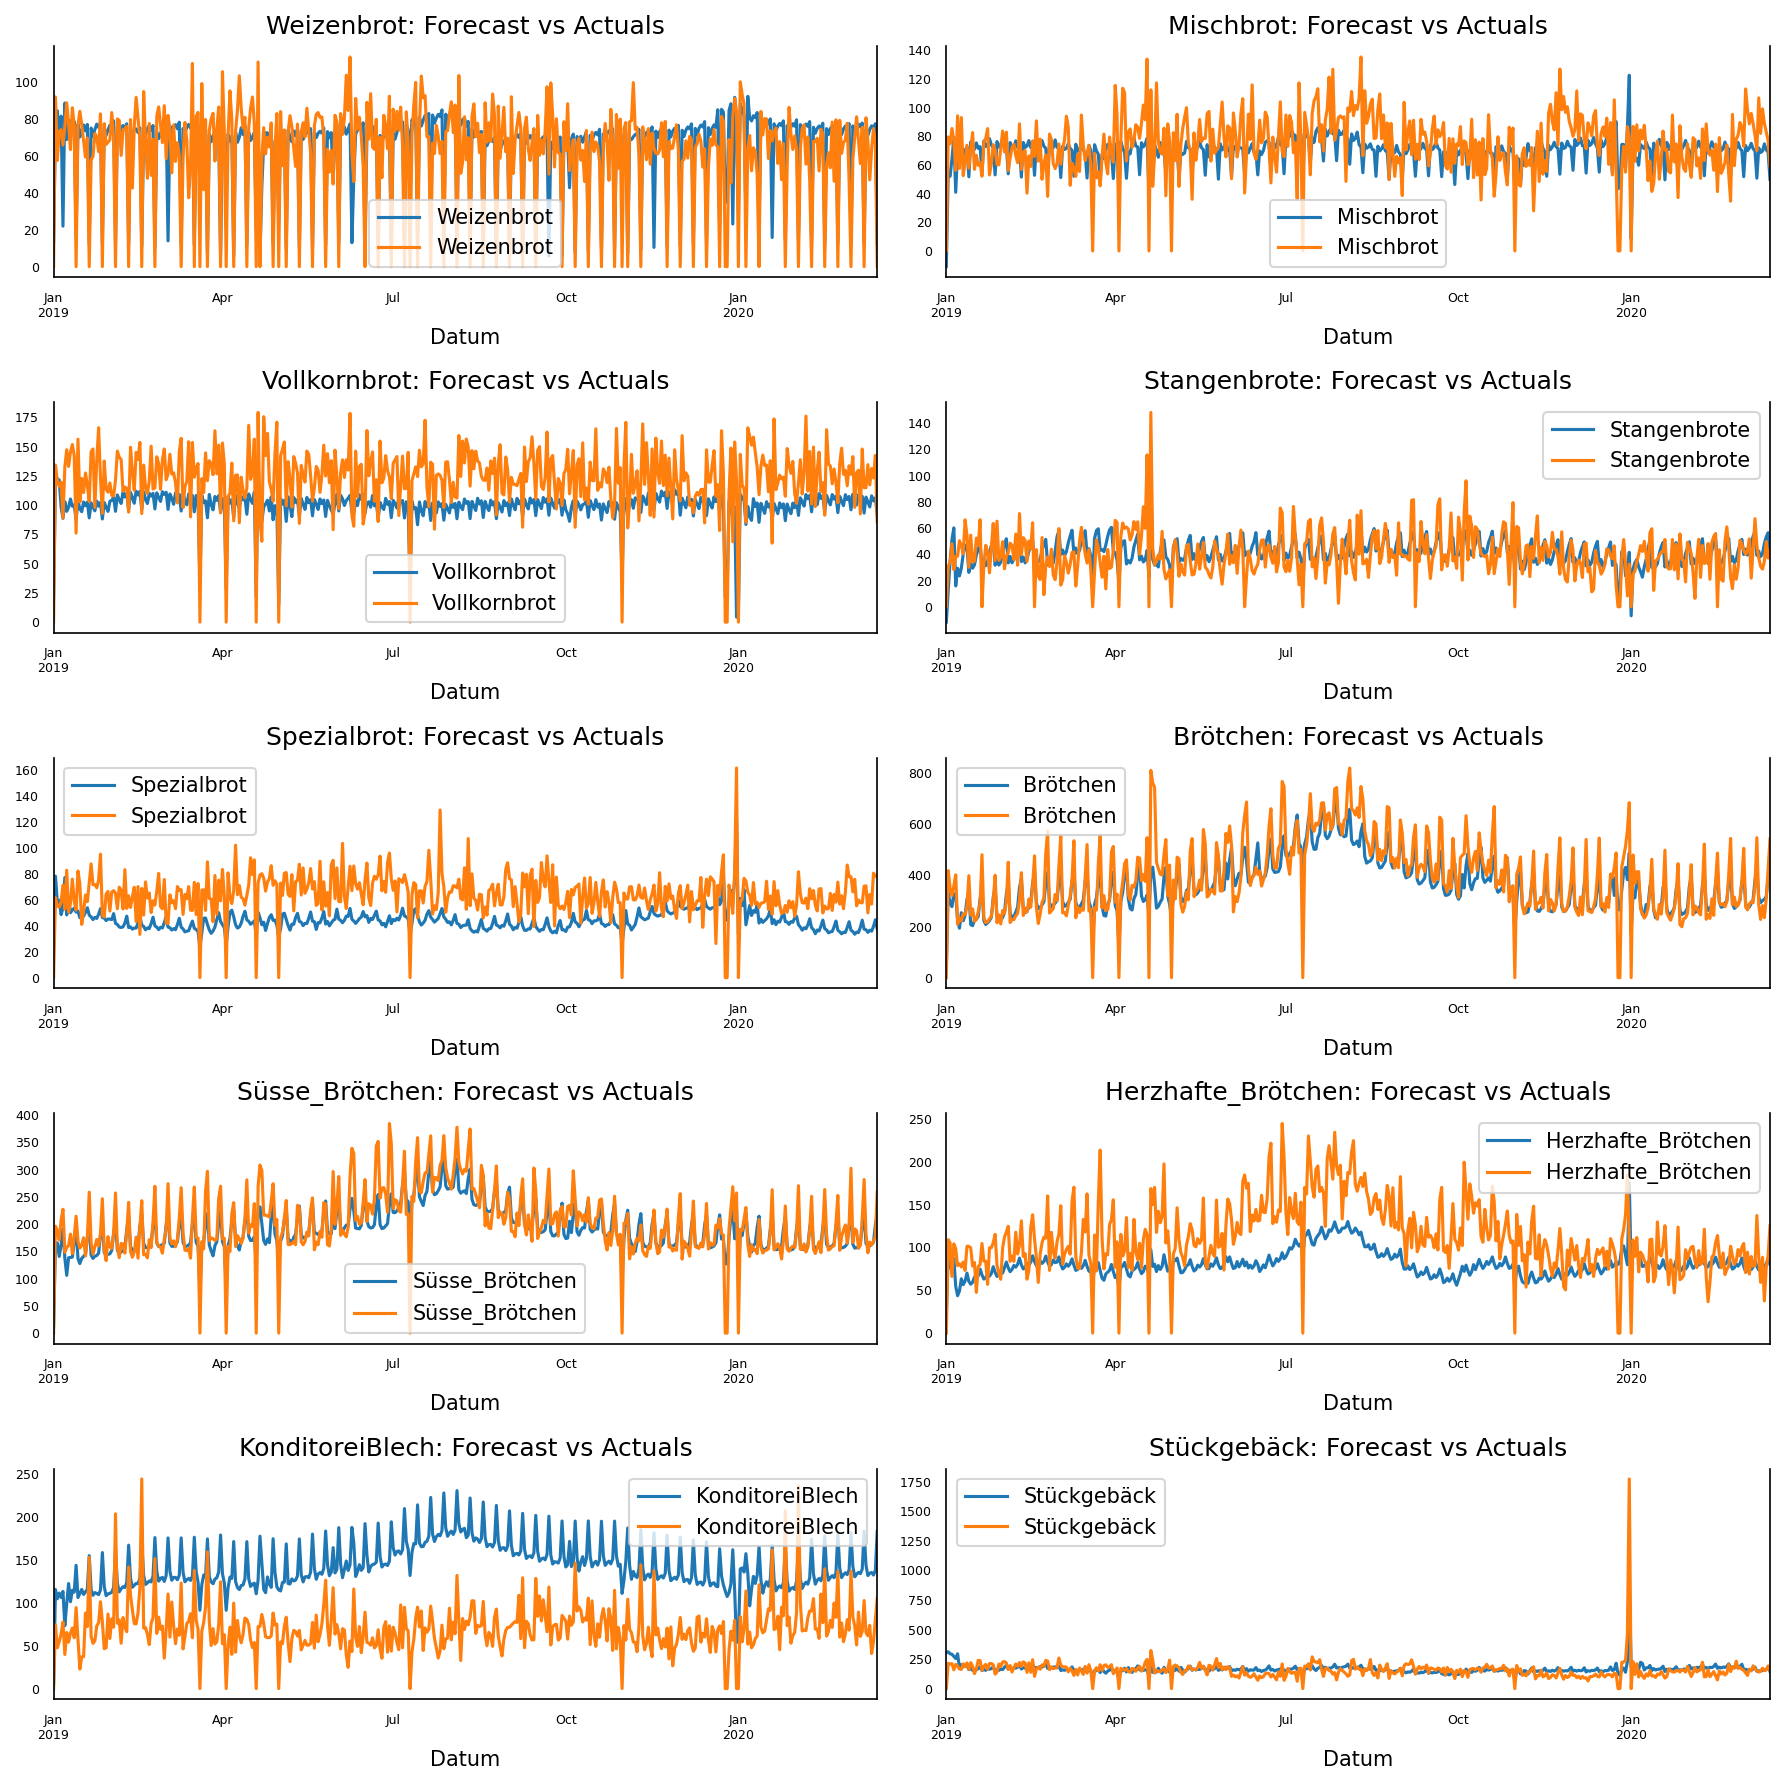

In [129]:
fig, axes = plt.subplots(nrows=int(len(df_basis_2_col.columns)/2), ncols=2, dpi=150, figsize=(12,12))
for i, (col,ax) in enumerate(zip(df_basis_2_col.columns, axes.flatten())):
    fc[col].plot(legend=True, ax=ax)
    #.autoscale(axis='x',tight=True)
    test_basis_2_col[col][-440:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
test_basis_2.shape

## Evaluate the Forecasts

In [142]:
df_results_VARMAX = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [131]:
article_selection=df_basis_2_col.columns.tolist()

In [143]:
for article in article_selection:
   name=article
   
   MAPE=mean_absolute_percentage_error(fc[name].values, test_basis_2_col[article])
   MAE=  mean_absolute_error(fc[name].values, test_basis_2_col[article])
                          
   df_results_VARMAX=df_results_VARMAX.append({'Model' : 'VARMAX' , 'Label' : article, 'MAE' : MAE,
                                               'MAPE' : MAPE} , ignore_index=True)
   #print(accuracy_prod)                                 



In [144]:
df_results_VARMAX 

Model               Label        MAE       MAPE
0   VARMAX          Weizenbrot  12.032389  33.696899
1   VARMAX           Mischbrot  14.341564  21.809540
2   VARMAX        Vollkornbrot  26.441000  33.826727
3   VARMAX        Stangenbrote  11.683339  30.116608
4   VARMAX         Spezialbrot  22.209541  53.184772
5   VARMAX            Brötchen  55.045549  15.595871
6   VARMAX      Süsse_Brötchen  22.584982  12.474085
7   VARMAX  Herzhafte_Brötchen  37.253222  46.282937
8   VARMAX     KonditoreiBlech  72.688157  50.907536
9   VARMAX         Stückgebäck  39.674445  23.527541
10  VARMAX         Blechkuchen  23.506305  35.508670

In [145]:
df_results_VARMAX.to_csv("Dateien/df_results_VARMAX.csv")